In [1]:
from importlib import reload

import os
import re

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as sk
import os
import re
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

from byc import constants, files, database, segmentation
from byc import standard_analysis as sa
from byc import plotting
from byc import fitting_tools as ft

from byc import constants, plotting, files, database, utilities, trace_tools, fitting_tools, segmentation
from byc import standard_analysis as sa
from byc.trace_tools import median_filter
median_filter
from importlib import reload
for pac in [constants,
            plotting,
            files,
            sa,
            database,
            utilities,
            trace_tools,
            fitting_tools,
            segmentation]:
    reload(pac)
    
plotting.set_styles(plt, matplotlib)


strains_color_dict = {
    'JPC000': (255/255, 102/255, 71/255),
    'JPC122': (255/255, 57/255, 86/255),
    'JPC121': (255/255, 147/255, 4/255),
    'JPC136': (108/255, 83/255, 83/255),
    'JPC193': (106/255, 0/255, 128/255),
    'JPC196': (237/255, 132/255, 223/255),
    'JPC199': (237/255, 132/255, 223/255),
}

## Generate fits, trace, and buds dataframes *de novo*

In [10]:
fits_df, traces_df = database.get_byc_fits_df(return_all_fits_df=True)
# Automatically label the fits_df where possible
fits_df = database.label_from_manual_byc_index(fits_df)
traces_df = database.label_from_manual_byc_index(traces_df)
BudDB = database.BudDataBase(fits_df)
buds_df = BudDB.buddf
# Screen out any data that was calculated erroneously
buds_df.loc[buds_df.dist_from_sen<2, 'cycle_duration_hrs'] = np.nan
# Added binning for decay trace summaries
bin_borders_dict = {
    1: (0, 7),
    2: (7, 15),
    3: (15, np.Inf)
}

traces_df.loc[:, 'dist_from_sen_bin'] = np.nan

for key, borders in bin_borders_dict.items():
    binmask = traces_df.dist_from_sen.between(borders[0], borders[1], inclusive='right')
    traces_df.loc[binmask, 'dist_from_sen_bin'] = str(borders)

# Add indices to differentiate multiple measurements in same cell
for df in [fits_df, traces_df, buds_df]:
    # Separates unique deacy rate measurements
    measdex = df.compartment_name.str.cat(df.cell_index.map(str), sep='-cell')
    df.loc[:, 'measdex'] = measdex
# Label the buds df and trace and fits dfs with their budding information.
# This will allow us to tell which measurements came from the same cell
# Separates unique cells (some have multiple decay rate measurements)
buds_df.loc[:, 'celldex'] = buds_df.compartment_name.str.cat(buds_df.bud_serial, sep='-bud_hours:')


Found date 20190726, compartment name 20190726_byc_pJC010_pdr5d_DsRed-P2A-UBL-YFP-NS
Found date 20190920, compartment name 20190920_byc_pJC010
Found date 20190920, compartment name 20190920_byc_pJC010_in_pdr5d_DsRed-P2A-UBL-YFP-Su9_CEN4
Found date 20190927, compartment name rpn4delta_pJC010_old_(002_003)
Found date 20190927, compartment name rpn4delta_pJC010_young_(001)
Found date 20191008, compartment name pdr5d_pJC010_young_chase
Found date 20210323, compartment name 20210323_byc_pJC272_BY4741_young_chase
Found date 20210323, compartment name 20210323_byc_pJC272_rpn4d_young_chase
Found date 20210401, compartment name 20210401_byc_pJC272_BY4741_old_chase
Found date 20210430, compartment name 20210430_(RKK-sYFP2-Su9)x2_JPC063_young_old_chase
Found date 20210507, compartment name 20210507_sYFP2-ODC_old_chase
Found date 20210514, compartment name 20210514_JPC063_RKK-sYFP2-Su9_old_chase
Found date 20210527, compartment name 20210527_sYFP2-ODC(47)x3_JPC082_pJC380_old_chase
Found date 20210

### Leaving this here to figure out how to do faster merging of celldex (includes bud serial) information from the buds df with traces and fits dfs

In [ ]:
buds_table = buds_df.pivot_table(index='measdex', aggfunc='first')

In [ ]:
buds_table = buds_df.pivot_table(index='measdex', aggfunc='first').reset_index()
suffs = ['', '_from_buds_df']
kwargs = {
    'on': 'measdex',
    'how': 'right',
    'lsuffix': suffs[0],
    'rsuffix': suffs[1]
}
joined = fits_df.join(buds_table.set_index(kwargs['on']), **kwargs)

In [ ]:
subdf.compartment_name.unique()

array(['20210910_JPC121_UbiR-YFP_su9x2_in_BYC4741_old_chase',
       '20220622_byc_JPC121_two-chase',
       '20220825_byc_JPC121_two-chase_1000xetOH'], dtype=object)

### Slow merging 

In [11]:
cols = [
    'celldex',
    'n_long_buds',
    'n_round_buds'
]

for df in [traces_df, fits_df]:
    df.loc[:, 'celldex'] = np.nan
    measdices = list(buds_df.measdex.unique())
    for i, measdex in enumerate(measdices):
        print(f'Annotating measurement {i+1} of {len(measdices)}', end="\r")
        if measdex in df.measdex.values:
            for col in cols:
                value = buds_df.set_index('measdex').loc[measdex, col].iloc[0]
                df.loc[df.measdex==measdex, col] = value

## Save trace, fits, and buds database dataframes

In [13]:
dfs = [traces_df, fits_df, buds_df]

names = [
    'traces_df.csv.gzip',
    'fits_df.csv.gzip',
    'buds_df.csv.gzip'
]

for i, df in enumerate(dfs):
    savepath = os.path.join(constants.byc_data_dir, f'meta/{names[i]}')
    df.to_csv(savepath, compression='gzip')
    print(f'Saved dataframe at\n{savepath}')

Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data\meta/traces_df.csv.gzip
Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data\meta/fits_df.csv.gzip
Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data\meta/buds_df.csv.gzip


## Read in databases

In [2]:
dfs = []

names = [
    'traces_df.csv.gzip',
    'fits_df.csv.gzip',
    'buds_df.csv.gzip'
]

for i, df in enumerate(names):
    savepath = os.path.join(constants.byc_data_dir, f'meta/{names[i]}')
    df = pd.read_csv(savepath, compression='gzip')
    dfs.append(df)
    print(f'Read dataframe at\n{savepath}')

traces_df, fits_df, buds_df = dfs

c:\.byc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (66,71,81,85,89,94,98) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data\meta/traces_df.csv.gzip
Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data\meta/fits_df.csv.gzip
Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data\meta/buds_df.csv.gzip


c:\.byc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,83,87,98,100,104) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Figure 1: A system to measure proteasome substrate turnover in continously observed replicatively aging cells

In [12]:
compartmentname = "20190726_byc_pJC010_pdr5d_DsRed-P2A_UBL-YFP-NS_rep_cell_64-65"
exptname = utilities.exptname_from_compartment(compartmentname)
filename = f'{compartmentname}_alldf_measured.csv.gzip'
compartmentdir = files.get_byc_compartmentdir(exptname, compartmentname)
allmeasuredpath = os.path.join(compartmentdir, filename)

# print(f'Reading all cells trace df from \n{allmeasuredpath}')
# allmeasureddf = pd.read_csv(allmeasuredpath, compression='gzip')
# # Split combined cell dataframes back into individual ce;ls
# tracedfs = [allmeasureddf[allmeasureddf.cell_index==cidx] for cidx in allmeasureddf.cell_index.unique()]
# table = pd.concat(tracedfs, sort=False)

filename = f'{exptname}_alldf.csv'
savepath = os.path.join(compartmentdir, filename)
table = pd.read_csv(savepath)
tracedfs = [table[table.cell_index==i] for i in table.cell_index.unique()]

# Read in the buddf for this cell
budspath = r"C:\Users\johnp\Dropbox\Projects\byc\data\20190726_byc\20190726_byc_pJC010_pdr5d_DsRed-P2A_UBL-YFP-NS_rep_cell_64-65\20190726_byc_cell000_bud_rois.zip"
budspath = os.path.abspath(budspath)
buddf = files.read_rectangular_rois_as_df(budspath)

buddf.loc[:, 'frame'] = buddf.position - 1
buddf.loc[:, 'bud_hour'] = (buddf.frame*10)/60
buddf.loc[buddf.index.max(), 'bud_hour'] = np.nan

df = tracedfs[0]
df.loc[:, 'hours'] = (df.frame_rel*10)/60

Figure saved at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\old_young_same_full_trace.png


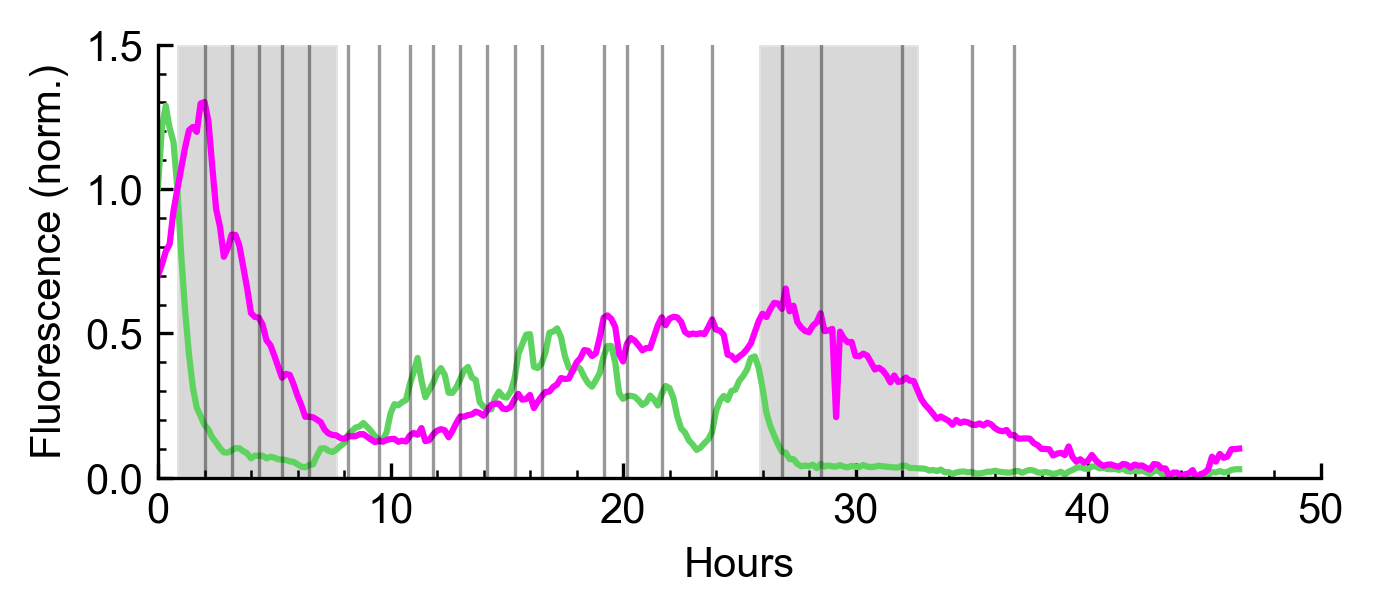

In [13]:
fig, ax = plotting.figure_ax(width_scale=2, height_scale=0.75)
fig.set_dpi(300)
chase_frame = 5
chase_frame2 = 155

x = df.hours

y1 = df.Mean_yfp_auto - df.Mean_yfp_auto.min()
y1 = y1/y1[chase_frame]
y2 = df.Mean_dsred_auto- df.Mean_dsred_auto.min()
y2 = y2/y2[chase_frame]
red  = (255/255, 0/255, 255/255)
green = (95/255, 211/255, 95/255)
ax.plot(x, y1, color=green)
ax.plot(x, y2, color=red)

ax.set_ylim(0, 1.5)
ax.set_xlim(0, 50)
plotting.format_ticks(ax)
ax.set_ylabel('Fluorescence (norm.)')
ax.set_xlabel('Hours')

x1 = np.arange((chase_frame*10)/60, (chase_frame*10)/60+7, 0.1)
x2 = np.arange((chase_frame2*10)/60, (chase_frame2*10)/60+7, 0.1)
y = np.full(len(x1), 1.5)
y2  = np.full(len(x2), 1.5)
ax.fill_between(x1, y, color='gray', alpha=0.3, edgecolor='white')
ax.fill_between(x2, y2, color='gray', alpha=0.3, edgecolor='white')
for bud_hour in buddf.bud_hour:
    ax.axvline(bud_hour, color='black', alpha=0.4, lw=0.8)
filename = 'old_young_same_full_trace.png'
path = os.path.join(constants.byc_data_dir, f'meta/plots/{filename}')
path = os.path.abspath(path)
fig.savefig(path)
print(f'Figure saved at\n{path}')

Figure saved at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\old_young_same_cell_decay.png


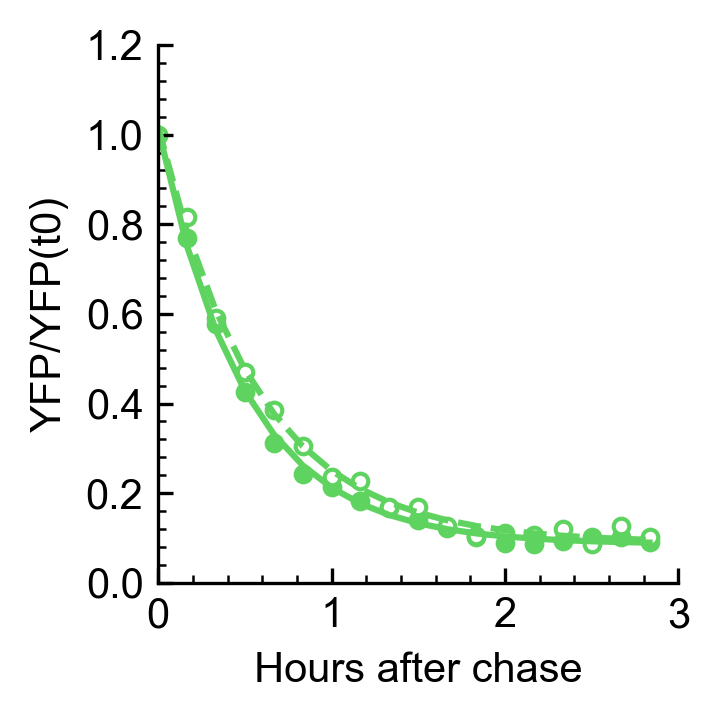

In [14]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
window = 18
x
old_color = (137/255, 207/255, 240/255)
young_color = 'black'

y = df.Mean_yfp_auto - df.Mean_yfp_auto.min()
y1 = y/y[chase_frame]
y1 = y1[chase_frame:chase_frame+window]
y2 = y/y[chase_frame2]
y2 = y2[chase_frame2:chase_frame2+window]

x = df.hours[0: window]
size=14
ax.scatter(x, y1, color=green, s=size)
ax.scatter(x, y2, color='white', s=size, edgecolor=green)

ax.set_xlim(0, 3)
ax.set_ylim(0, 1.2)
plotting.format_ticks(ax)

popt1, pcov = fitting_tools.curve_fit(fitting_tools.single_exp, x, y1)
popt2, pcov = fitting_tools.curve_fit(fitting_tools.single_exp, x, y2)
y_pred1 = fitting_tools.single_exp(x, *popt1)
y_pred2 = fitting_tools.single_exp(x, *popt2)

ax.plot(x, y_pred1, color=green)
ax.plot(x, y_pred2, color=green, linestyle='--')
ax.set_xlabel('Hours after chase')
ax.set_ylabel('YFP/YFP(t0)')
plt.tight_layout()
filename = 'old_young_same_cell_decay.png'
path = os.path.join(constants.byc_data_dir, f'meta/plots/{filename}')
path = os.path.abspath(path)
fig.savefig(path)
print(f'Figure saved at\n{path}')

## Figure 2: Ubiquitin-independent proteasome substrate turnover is independent of replicative age

### Plots of aggregated fluorescence traces - two-color version

Establish color palettes

c:\.byc\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\.byc\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\.byc\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC196_YFP_vs._time_with_color_for_dist-from-sen.png


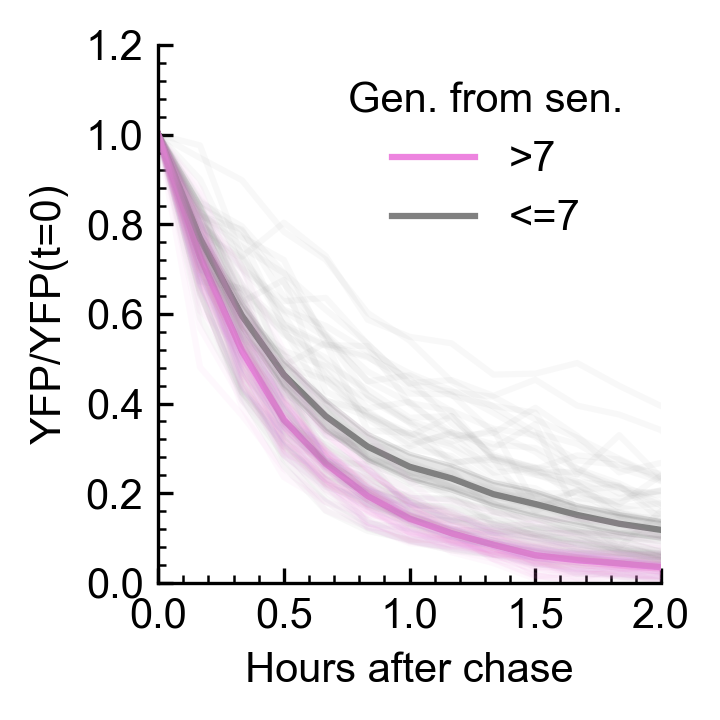

In [6]:
strains = ['JPC196']
color_dict = {
    'UBL': (212/255, 0/255, 170/255),
    'ODC': (255/255, 0/255, 102/255),
    'R*': (255/255, 147/255, 4/255)
}
ratecolor = strains_color_dict[strains[0]]
name= '-'.join(strains)

filename = f'{name}'
sub_traces_df = traces_df[traces_df.strain_name.isin(strains)]
sub_traces_df.loc[:, 'measdex'] = sub_traces_df.measdex.str.cat(sub_traces_df.dist_from_sen.astype(str), sep='-')
sub_traces_df.loc[:, 'dist_from_sen_bin'] = '>7'
sub_traces_df.loc[sub_traces_df.dist_from_sen<=7, 'dist_from_sen_bin'] = '<=7'
sub_traces_df.dropna(subset=['dist_from_sen_bin'], inplace=True)

colors = [ratecolor, 'gray']
keys = [
    '>7',
    '<=7'
]
palette_dict = dict(zip(keys, colors))

fig = plt.figure(figsize=(2.5, 2.5))
fig.set_dpi(300)
yvar = 'y_input_norm'
xvar = 'x_input'
huevar = 'dist_from_sen_bin'
ax = fig.add_subplot(111)
alpha = 0.05
size =14
fontsize=10
linewidth = 1
xlim = (0, 2)
ylim = (0, 1.2)
ylabel = 'YFP/YFP(t=0)'
xlabel = 'Hours after chase'

linekwargs = {
    'x': xvar,
    'y': yvar,
    'data': sub_traces_df,
    'hue': huevar,
    'palette': colors,
    'ax': ax,
    'estimator': 'mean',
    'hue_order': keys
}
sns.lineplot(**linekwargs)
previous_measdices = []
for measdex in sub_traces_df.measdex.unique():
    # Making sure I don't plot duplicates
    if measdex not in previous_measdices:
        subdf = sub_traces_df.set_index('measdex').loc[measdex, :].reset_index()
        subdf.sort_values(by=xvar, inplace=True, ascending=True)
        bin_name = subdf.loc[0, 'dist_from_sen_bin']
        color = palette_dict[bin_name]
        ax.plot(subdf[xvar], subdf[yvar], color=color, alpha=alpha)
    else:
        print(f'Duplicate measurements:\n{measdex}')
    previous_measdices.append(measdex)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([0, 0.5, 1, 1.5, 2])

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=0.1)

ax.set_ylabel(ylabel, fontsize=fontsize, color='black')
ax.set_xlabel(xlabel, fontsize=fontsize)

L=ax.legend(title="Gen. from sen.", frameon=False)
labels = ['>7', '<=7']

for idx in range(len(labels)):
    L.get_texts()[idx].set_text(labels[idx])

if filename != None:
    prefix = filename
else:
    prefix = "-".join(strains)

filtype = '.png'
savepath = os.path.join(os.getcwd(), f'plots\\{prefix}_YFP_vs._time_with_color_for_dist-from-sen{filtype}')
plt.tight_layout()
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

### Aggregate fluorescence traces - one color per gen from sen

c:\.byc\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\.byc\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\.byc\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC121_YFP_vs._time_with_color_for_dist-from-sen.png


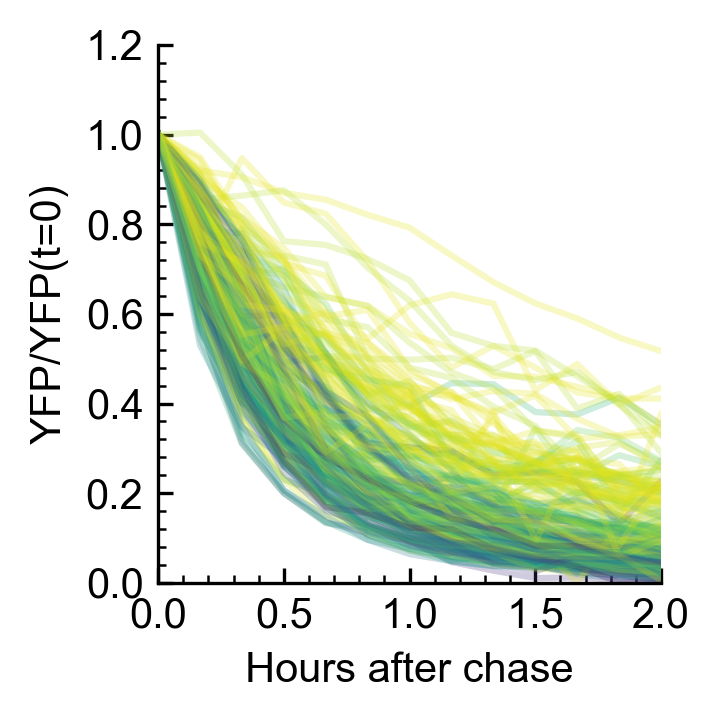

In [140]:
strains = ['JPC121']

compartments = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]
sub_traces_df = traces_df[traces_df.compartment_name.isin(compartments)]
ratecolor = strains_color_dict[strains[0]]
name= '-'.join(strains)
max_dist_from_sen = 25
plot_means = False
filename = f'{name}'
sub_traces_df = traces_df[traces_df.strain_name.isin(strains)]
sub_traces_df.loc[:, 'measdex'] = sub_traces_df.measdex.str.cat(sub_traces_df.dist_from_sen.astype(str), sep='-')
sub_traces_df.loc[:, 'dist_from_sen_bin'] = '>7'
sub_traces_df.loc[sub_traces_df.dist_from_sen<=7, 'dist_from_sen_bin'] = '<=7'
sub_traces_df.dropna(subset=['dist_from_sen_bin'], inplace=True)

colors = sns.color_palette('viridis', max_dist_from_sen+1)
colors_list = [c for c in colors]
colors_list.reverse()
keys = list(range(max_dist_from_sen+1))
palette_dict = dict(zip(keys, colors_list))

wanted = [
    2,
    20
    ]
median_colors = [colors_list[i] for i in wanted]

fig = plt.figure(figsize=(2.5, 2.5))
fig.set_dpi(300)
yvar = 'y_input_norm'
xvar = 'x_input'
huevar = 'dist_from_sen_bin'
ax = fig.add_subplot(111)
alpha = 0.25
size =14
fontsize=10
linewidth = 1
xlim = (0, 2)
ylim = (0, 1.2)
ylabel = 'YFP/YFP(t=0)'
xlabel = 'Hours after chase'

previous_measdices = []
for measdex in sub_traces_df.measdex.unique():
    # Making sure I don't plot duplicates
    if measdex not in previous_measdices:
        subdf = sub_traces_df.set_index('measdex').loc[measdex, :].reset_index()
        subdf.sort_values(by=xvar, inplace=True, ascending=True)
        bin_name = subdf.loc[0, 'dist_from_sen_bin']
        dist_from_sen = subdf.loc[0, 'dist_from_sen']
        key = int(dist_from_sen)
        if key > max_dist_from_sen:
            key = max_dist_from_sen
        color = palette_dict[key]
        ax.plot(subdf[xvar], subdf[yvar], color=color, alpha=alpha)
    else:
        print(f'Duplicate measurements:\n{measdex}')
    previous_measdices.append(measdex)


linekwargs = {
    'x': xvar,
    'y': yvar,
    'data': sub_traces_df,
    'hue': huevar,
    'ax': ax,
    'estimator': 'mean',
    'palette': median_colors,
    'hue_order': sub_traces_df[huevar].unique()
}
if plot_means:
    sns.lineplot(**linekwargs)
    L=ax.legend(title="Buds before death.", frameon=False)
    labels = sub_traces_df[huevar].unique()

    for idx in range(len(labels)):
        L.get_texts()[idx].set_text(labels[idx])


ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([0, 0.5, 1, 1.5, 2])

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=0.1)

ax.set_ylabel(ylabel, fontsize=fontsize, color='black')
ax.set_xlabel(xlabel, fontsize=fontsize)


if filename != None:
    prefix = filename
else:
    prefix = "-".join(strains)

filtype = '.png'
savepath = os.path.join(os.getcwd(), f'plots\\{prefix}_YFP_vs._time_with_color_for_dist-from-sen{filtype}')
plt.tight_layout()
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

C:\Users\johnp\AppData\Local\Temp/ipykernel_27884/2259890123.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.savefig(savepath)
c:\.byc\lib\site-packages\IPython\core\events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  func(*args, **kwargs)


Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\gen_from_death_color_palette.png


c:\.byc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


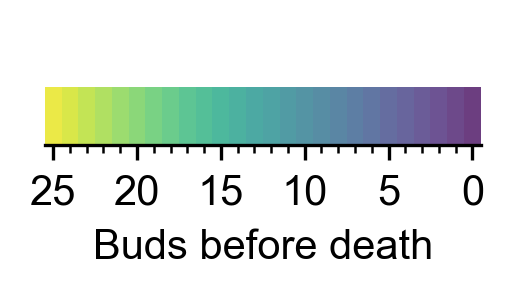

In [62]:
max_dist_from_sen = 25

colors = sns.color_palette('viridis', max_dist_from_sen+1)
colors_list = [c for c in colors]

# Plot the continuous legend
fig, ax = plotting.figure_ax(height_scale=0.2, width_scale=0.75)
fig.set_dpi(300)
alpha = 0.8
chase_frame = 10
chase_frame2 = 140
x1 = np.arange(0, max_dist_from_sen, 1)
y = np.full(len(x1), 1)
colors_list_alpha = [matplotlib.colors.to_rgba(c, alpha) for c in colors_list]
for i, color in enumerate(colors_list_alpha):
    x = np.arange(i-0.5, i+1.5, 1)
    y = np.full(len(x), 0.5)
    ax.fill_between(x, y, color=color, edgecolor=None)

ax.set_ylim(0, 1)
ax.set_xlim( 25.5, -0.5)
xticks = [0, 5, 10, 15, 20, 25]
xticks.reverse()
ax.set_xticks(xticks)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
plotting.format_ticks(ax, tickdirection='out')
ax.set_xlabel("Buds before death")

filetype = '.png'
savepath = os.path.join(os.getcwd(), f'plots\\gen_from_death_color_palette{filetype}')
fig.set_tight_layout(True)
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

### Logistic fit to b vs. dist from sen curve

In [28]:
reload(fitting_tools)

<module 'byc.fitting_tools' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\fitting_tools.py'>

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.png


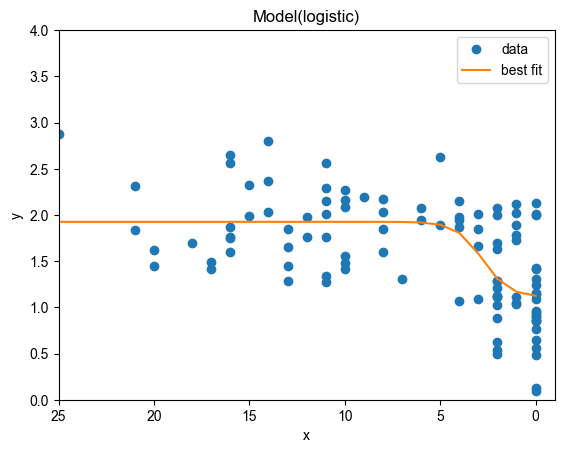

<Figure size 640x480 with 0 Axes>

In [29]:
strains = ['JPC122']
comps = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]
sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
sub_fits_df = fits_df[fits_df.compartment_name.isin(comps)]
fitsdf, result = fitting_tools.fit_logistic_to_fits_df(
    sub_fits_df,
    plot_results=True,
    return_result=True)

In [32]:
fitsdf.old_decay_ratel

0    0.814623
Name: old_decay_rate, dtype: float64

In [17]:
result.

array([1.89603506, 2.87242806, 1.83313279, 2.30999344, 1.62527377,
       1.44648141, 1.70121156, 1.49524369, 1.4131909 , 1.75979134,
       1.86873651, 2.56367179, 1.59575081, 2.64579627, 1.75189342,
       1.98424012, 2.32556177, 2.02996005, 2.80446306, 2.37147675,
       1.85053861, 1.44733931, 1.28854424, 1.65647517, 1.97288249,
       1.75849445, 2.01269194, 1.75914326, 2.29160899, 1.27366391,
       2.15528318, 1.3422546 , 2.56546836, 2.08044967, 1.48130994,
       2.27269553, 1.41401782, 1.55066953, 2.16110315, 2.19355173,
       2.02641679, 1.85161363, 1.59916907, 2.16738296, 1.30469248,
       1.94151935, 2.07893467, 1.89565606, 2.63055125, 1.94178374,
       1.06843865, 1.97899097, 1.86646277, 2.15291611, 2.0084027 ,
       1.08889524, 1.84657767, 1.65995983, 1.63478076, 0.62966953,
       1.03032371, 1.20866399, 0.49182374, 1.12027862, 1.69952188,
       0.88851788, 2.07461404, 1.99978053, 0.53561768, 1.28194731,
       1.28544365, 1.10980369, 1.12260816, 2.12104445, 1.73225

### Linear fit to b vs. dist from sen curve


In [320]:
reload(fitting_tools)

<module 'byc.fitting_tools' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\fitting_tools.py'>

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC193_linear-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC193_linear-fit_b-vs-dist-from-sen.png


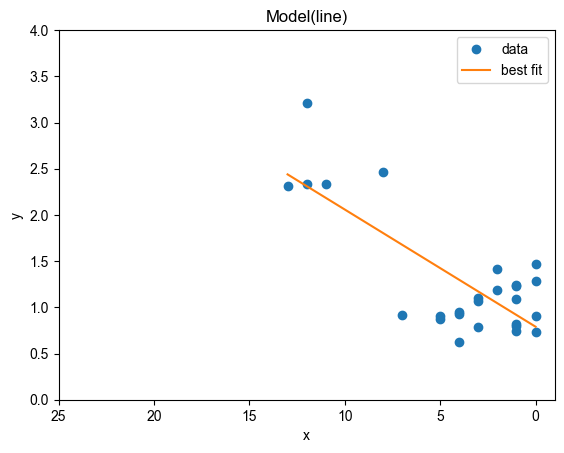

<Figure size 640x480 with 0 Axes>

In [328]:
strains = ['JPC193']
comps = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]
sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
# sub_fits_df = fits_df[fits_df.compartment_name.isin(comps)]
fitsdf = fitting_tools.fit_line_to_fits_df(sub_fits_df)

### rpn4&Delta; dependence of ODC(47) and UBL

In [26]:
data_dir = constants.flow_data_dir
wanted_expts = [
    '20210721',
    '20210714',
    '20210708',
    '20210329',
    '20210329',
    '20210415',
    '20210430'
]

dfs = []
for expt in wanted_expts:
    filename = f'{expt}_data_agg.csv'
    filepath = os.path.join(data_dir, f'{expt}/{filename}')
    filepath= os.path.abspath(filepath)
    df = pd.read_csv(filepath)
    print(f'Read flow agg .csv from\n{filepath}')
    dfs.append(df)
flowdf = pd.concat(dfs, sort=False).reset_index()

Read flow agg .csv from
C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210721\20210721_data_agg.csv
Read flow agg .csv from
C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210714\20210714_data_agg.csv
Read flow agg .csv from
C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210708\20210708_data_agg.csv
Read flow agg .csv from
C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210329\20210329_data_agg.csv
Read flow agg .csv from
C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210329\20210329_data_agg.csv
Read flow agg .csv from
C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210415\20210415_data_agg.csv
Read flow agg .csv from
C:\Users\johnp\Box\Finkelstein-Matouschek\flow_cytometry\20210430\20210430_data_agg.csv


In [28]:
flowdf[flowdf.plasmid.isin(['pJC031'])].expt_date.unique()

array([20210708., 20210329., 20210415., 20210430.])

In [35]:
flowdf.expt_date.unique()

array([20210721., 20210708., 20210329., 20210415., 20210430.])

In [40]:
subdfdd

Empty DataFrame
Columns: [level_0, sample_id, substrate, plasmid, expr_method, Chase_method, background, minutes, hours, strain, genotype, 7-AAD-A, APC-A, APC-Cy7-A, Alexa Fluor 405-A, Alexa Fluor 430-A, Alexa Fluor 488-A, Alexa Fluor 488-A_bg_norm, Alexa Fluor 488-A_bg_sub, Alexa Fluor 700-A, DsRed-A, DsRed-A_bg_norm, DsRed-A_bg_sub, FSC-A, FSC-H, FSC-W, PE-A, PE-Cy5-5-A, PE-Cy7-A, PerCP-Cy5-5-A, Qdot 605-A, SSC-A, SSC-H, SSC-W, Time, clone, expt_date, index, sample_index, yfp_norm, rfp_norm, Unnamed: 0, Unnamed: 0.1]
Index: []

[0 rows x 43 columns]

In [46]:
expt_dates = subdf.expt_date.unique()
expt_dates[0]

20210708.0

In [53]:
subdf.expt_date.unique()

array([20210708.])

In [59]:
flowdf[flowdf.plasmid=='pJC031'].columns

Index(['level_0', 'sample_id', 'substrate', 'plasmid', 'expr_method',
       'Chase_method', 'background', 'minutes', 'hours', 'strain', 'genotype',
       '7-AAD-A', 'APC-A', 'APC-Cy7-A', 'Alexa Fluor 405-A',
       'Alexa Fluor 430-A', 'Alexa Fluor 488-A', 'Alexa Fluor 488-A_bg_norm',
       'Alexa Fluor 488-A_bg_sub', 'Alexa Fluor 700-A', 'DsRed-A',
       'DsRed-A_bg_norm', 'DsRed-A_bg_sub', 'FSC-A', 'FSC-H', 'FSC-W', 'PE-A',
       'PE-Cy5-5-A', 'PE-Cy7-A', 'PerCP-Cy5-5-A', 'Qdot 605-A', 'SSC-A',
       'SSC-H', 'SSC-W', 'Time', 'clone', 'expt_date', 'index', 'sample_index',
       'yfp_norm', 'rfp_norm', 'Unnamed: 0', 'Unnamed: 0.1'],
      dtype='object')

In [71]:
subdf.sample_id.unique()

array(['A03', 'B09', 'B04', 'B08', 'A10', 'A08'], dtype=object)

In [75]:
subdf.sample_id.unique()

array(['A03', 'B09', 'B04', 'B08', 'A10', 'A08'], dtype=object)

In [83]:
subdf.Chase_method.unique()

array(['250 uM Tet'], dtype=object)

c:\.byc\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\.byc\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


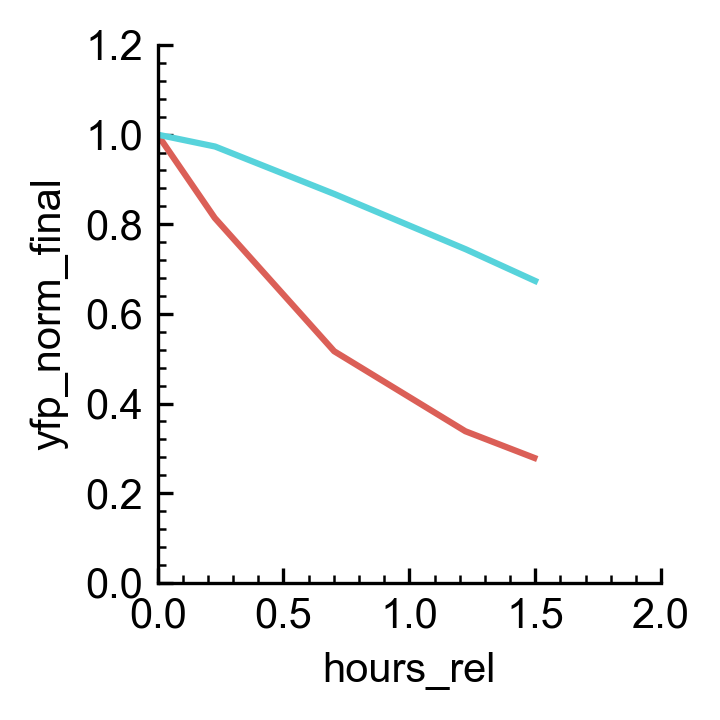

In [119]:
subdf = flowdf[flowdf.plasmid.isin(['pJC380'])]
subdf = subdf[subdf.background.isin(['BY4741', 'rpn4d'])]
subdf = subdf[subdf.sample_id.isin(['A08', 'B09'])]
subdf = subdf[subdf.expt_date==expt_dates[0]]
subdf.sort_values(by='hours', inplace=True)
chaseframe = 4
subdf.loc[:, 'yfp_norm_final'] = np.nan
sample_dfs = []
for sample_id in subdf.sample_id.unique():
    sample_df = subdf.loc[subdf.sample_id==sample_id, :]
    yfp_norm = sample_df.yfp_norm/sample_df.yfp_norm.iloc[chaseframe]
    sample_df.loc[:, 'yfp_norm_final'] = yfp_norm
    sample_df.loc[:, 'hours_rel'] = sample_df.hours - sample_df.hours.iloc[chaseframe]
    sample_dfs.append(sample_df)

subdf = pd.concat(sample_dfs, sort=False)

fig, ax = plotting.figure_ax()
fig.set_dpi(300)

kwargs = {
    'x': 'hours_rel',
    'y': 'yfp_norm_final',
    'data': subdf,
    'hue': 'background',
    'ax': ax,
    'palette': 'hls'
}

sns.lineplot(**kwargs)

ax.set_ylim(0, 1.2)
ax.set_xlim(0, 2)
plotting.format_ticks(ax)

plt.tight_layout()
ax.legend_.set_visible(False)
fig.savefig('pJC380_rpn4_sensitivity.png')

In [104]:
subdf.expt_date.unique()

array([20210708., 20210415., 20210430., 20210329.])

c:\.byc\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\.byc\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


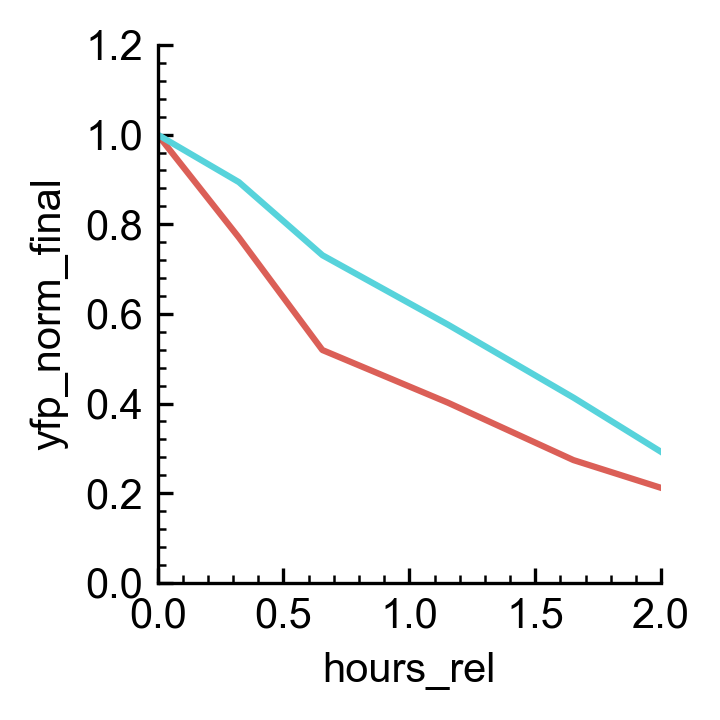

In [116]:
subdf = flowdf[flowdf.plasmid.isin(['pJC031'])]
# subdf = subdf[subdf.background.isin(['BY4741', 'rpn4d'])]
# subdf = subdf[subdf.sample_id.isin(['A01', 'B12'])]
subdf = subdf[subdf.expt_date==expt_dates[3]]
subdf.sort_values(by='hours', inplace=True)
chaseframe = 2
subdf.loc[:, 'yfp_norm_final'] = np.nan
sample_dfs = []
for sample_id in subdf.sample_id.unique():
    sample_df = subdf.loc[subdf.sample_id==sample_id, :]
    yfp_norm = sample_df.yfp_norm/sample_df.yfp_norm.iloc[chaseframe]
    sample_df.loc[:, 'yfp_norm_final'] = yfp_norm
    sample_df.loc[:, 'hours_rel'] = sample_df.hours - sample_df.hours.iloc[chaseframe]
    sample_dfs.append(sample_df)

subdf = pd.concat(sample_dfs, sort=False)

fig, ax = plotting.figure_ax()
fig.set_dpi(300)

kwargs = {
    'x': 'hours_rel',
    'y': 'yfp_norm_final',
    'data': subdf,
    'hue': 'background',
    'ax': ax,
    'palette': 'hls'
}

sns.lineplot(**kwargs)

ax.set_ylim(0, 1.2)
ax.set_xlim(0, 2)
plotting.format_ticks(ax)

plt.tight_layout()
ax.legend_.set_visible(False)
fig.savefig('pJC031_rpn4_sensitivity.png')

### Rate vs. buds from death plots

In [108]:
reload(fitting_tools)

<module 'byc.fitting_tools' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\fitting_tools.py'>

In [196]:
result.get

In [200]:
reload(fitting_tools)

<module 'byc.fitting_tools' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\fitting_tools.py'>

In [203]:
ax.get_xlim()

(25.0, -1.0)

In [258]:
reload(fitting_tools)

<module 'byc.fitting_tools' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\fitting_tools.py'>

In [267]:
reload(fitting_tools)

<module 'byc.fitting_tools' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\fitting_tools.py'>

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC193_logistic-fit_b-vs-dist-from-sen.csv
Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC193_Allk_and_cycle_vs._dist_from_sen_filledsep=False_fittype=logistic.png


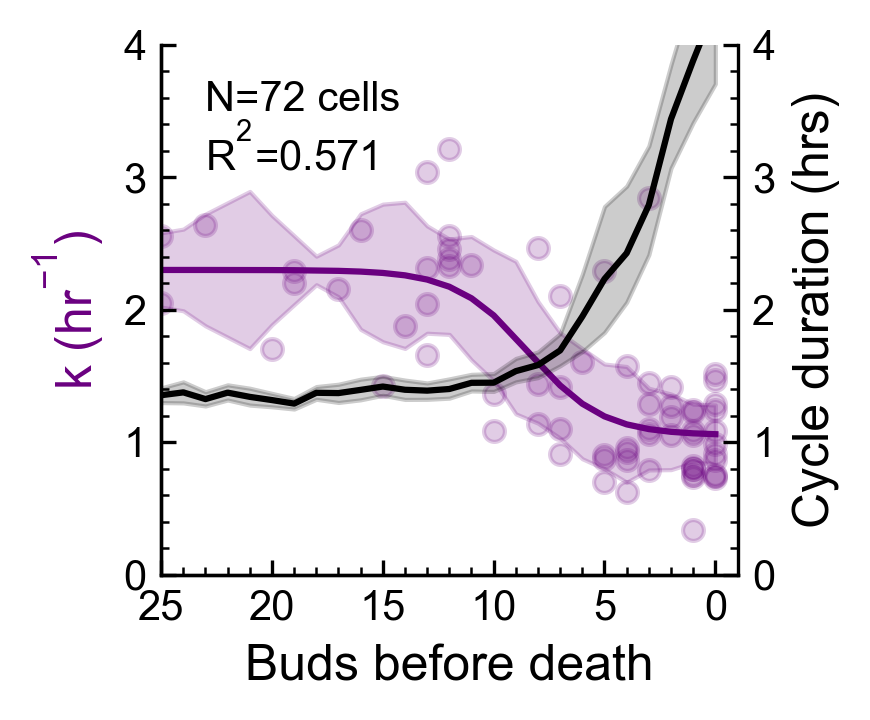

In [280]:
strains = ['JPC193']
compartments = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]

sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
sub_bud_df = buds_df[buds_df.strain_name.isin(strains)]

if strains == ['JPC121']:
    sub_fits_df = fits_df[fits_df.compartment_name.isin(compartments)]
    sub_bud_df = buds_df[buds_df.compartment_name.isin(compartments)]

ratecolor = strains_color_dict[strains[0]]
pre_post_SEP_palette = [
    (42/255, 212/255, 255/255),
    (153/255, 153/255, 153/255)
]

fit_type = 'logistic'
shade_stderr = True
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax(width_scale=1.2)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs_meanfilt_3'
xvar = 'dist_from_sen'
alpha = 0.785
size = 15
fontsize=12
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'
if fillsep:
    # Shade post-SEP area
    xfill = np.arange(-1, 7, 1)
    ax.fill_between(
        xfill,
        np.full(len(xfill), 4),
        color=pre_post_SEP_palette[1],
        alpha=fillalpha,
        edgecolor=None)
    # Shade post-SEP area
    xfill = np.arange(7, 26, 1)
    ax.fill_between(
        xfill,
        np.full(len(xfill), 4),
        color=pre_post_SEP_palette[0],
        alpha=fillalpha,
        edgecolor=None)

if fit_type=='logistic':
    # fit to logistic
        fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
        x = np.sort(sub_fits_df[xvar].unique())
        y_pred = fitting_tools.logistic(x, *params)
elif fit_type=='line':
    # Fit to line
    fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
    kernsize = 3
    trace_tools.mean_filter(
        smoothdf,
        'stderr',
        kernsize,
        name_with_kernel=True)  

    params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
    y_pred = fitting_tools.line(x, *params)

else:
    print(f'No fit type <{fit_type}>. Please use either logistic or line')
# Derive statistics of fit
r_sq = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df)
n = len(sub_fits_df)
# Shade standard error of the mean for 
if shade_stderr:
    xvar_fill = 'x_input_smooth'
    yvar_fill = 'y_pred'
    errvar = f'stderr_meanfilt_{kernsize}'
    # errvar = f'stderr'

    err_kwargs = {
        'x': smoothdf[xvar_fill],
        'y1': smoothdf[yvar_fill] + smoothdf[errvar],
        'y2': smoothdf[yvar_fill] - smoothdf[errvar]
    }

    kwargs = {
        'x': xvar_fill,
        'y': 'y_pred',
        'data': smoothdf,
        'err_kws': err_kwargs
    }
    ax.fill_between(
        err_kwargs['x'],
        err_kwargs['y1'],
        err_kwargs['y2'],
        color=ratecolor,
        alpha=0.2
        )
# Formatting stuff
ax.set_xlim(25, -1)
ax.set_xticks([25, 20, 15, 10, 5, 0])
ax.set_ylim(0, 4)

ax2 = ax.twinx()
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 4)

colors = sns.palettes.color_palette('hls', 3)
ax.scatter(sub_fits_df[xvar], sub_fits_df[yvar1], color=ratecolor,
           edgecolor=None, alpha=0.2, s=25)
ax.plot(x, y_pred, color=ratecolor)
# plot cycl durations
sns.lineplot(x=xvar, y=yvar2, data=sub_bud_df,ax=ax2, color='black')

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=1)
plotting.format_ticks(ax2, xminorspace=1)

ax2.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_ylabel(ylabel2, fontsize=fontsize, color=ratecolor)
ax.set_xlabel(xlabel, fontsize=fontsize)

# Annotate stats
xy_n = (23, 3.5)
xy_rsq = (23, 3.05)
rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 3)}'
n_str = f'N={np.round(n, 2)} cells'
ax.annotate(rsq_str, xy_rsq)
ax.annotate(n_str, xy_n)
name = '-'.join(strains)
savepath = os.path.join(os.getcwd(), f'plots\\{name}_{daughter_shape}k_and_cycle_vs._dist_from_sen_filledsep={fillsep}_fittype={fit_type}.png')

plt.tight_layout()
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

#### Working on error shading for fits

In [239]:
trace_tools.mean_filter??

Signature:
trace_tools.mean_filter(
    df,
    column_name,
    kernel_size,
    name_with_kernel=False,
)
Docstring: <no docstring>
Source:   
def mean_filter(df, column_name, kernel_size, name_with_kernel=False):
    assert np.mod(kernel_size, 2) == 1, 'kernel_size must be odd and > 1'    
    
    offset = (kernel_size - 1)/2
    
    new_col_name = f'{column_name}_meanfilt'
    if name_with_kernel:
        new_col_name = f'{new_col_name}_{kernel_size}'
    else:
        pass
    
    for i in range(len(df.loc[:, column_name])):
        
        lower = i - offset
        upper = i + offset
        if lower < 0:
            upper = upper + abs(lower)
            lower = 0

        elif upper >=len(df.loc[:, column_name]):
            upper = i
            
        mean_of_kernel = np.mean(df.loc[lower:upper, column_name])
        df.loc[i, new_col_name] = mean_of_kernel
        
    # return df
File:      c:\users\johnp\dropbox\projects\byc\byc\trace_tools.py
Type:      function


In [240]:
trace_tools.mean_filter(
    smoothdf,
    'stderr',
    3)

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.csv


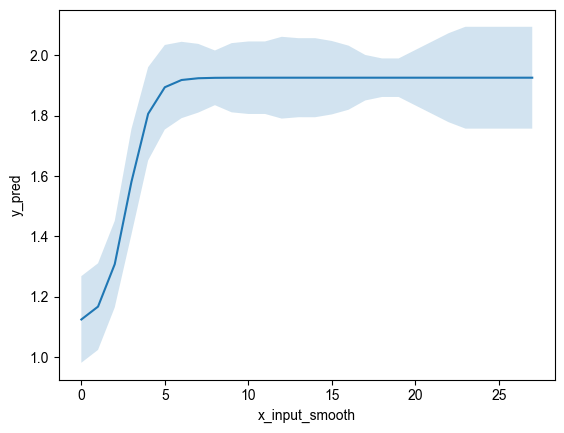

In [245]:
fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
kernsize = 5
trace_tools.mean_filter(
    smoothdf,
    'stderr',
    kernsize,
    name_with_kernel=True)
xvar = 'x_input_smooth'
yvar = 'y_pred'
errvar = f'stderr_meanfilt_{kernsize}'

err_kwargs = {
    'x': smoothdf[xvar],
    'y1': smoothdf[yvar] + smoothdf[errvar],
    'y2': smoothdf[yvar] - smoothdf[errvar]
}

kwargs = {
    'x': 'x_input_smooth',
    'y': 'y_pred',
    'data': smoothdf,
    'err_kws': err_kwargs
}

sns.lineplot(**kwargs)
plt.fill_between(err_kwargs['x'], err_kwargs['y1'], err_kwargs['y2'], alpha=0.2)

Saved figure at 
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\fig2_pre-post-SEP_summary.png


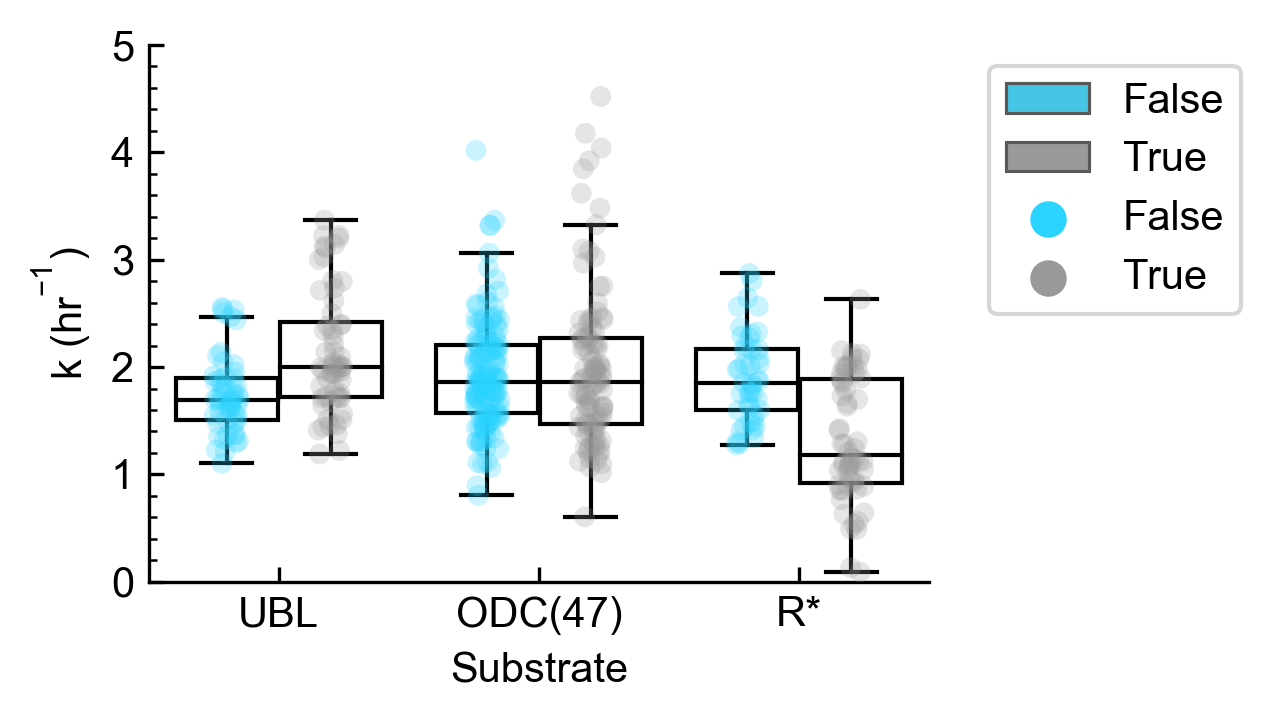

In [237]:
JPC121_drops = [
    '20210910_JPC121_UbiR-YFP_su9x2_in_BYC4741_old_chase',
    '20210910_JPC121_UbiR-YFP_su9x2_in_BYC4741_young_chase',
    '20220622_byc_JPC121_two-chase'
]

fits_df.loc[:, 'post-sep'] = False
fits_df.loc[fits_df.dist_from_sen<=6, 'post-sep'] = True
fits_df.loc[fits_df.dist_from_sen>7, 'post-sep'] = False
strains = ['JPC000', 'JPC122', 'JPC121']
# pre_post_SEP_palette = [matplotlib.colors.to_rgba(color) for color in pre_post_SEP_palette]
my_cmap = matplotlib.colors.ListedColormap(pre_post_SEP_palette)

subdf = fits_df[fits_df.strain_name.isin(strains)]
subdf = subdf[~subdf.compartment_name.isin(JPC121_drops)]
fig, ax = plotting.figure_ax(width_scale = 1.75)
fig.set_dpi(300)

stripkwargs = {
    'x': 'strain_name',
    'y': 'b',
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': strains,
    'ax': ax,
    'dodge': True,
    'data': subdf,
    'palette': pre_post_SEP_palette,
    'alpha': 0.25
}

sns.stripplot(**stripkwargs)

boxkwargs = {
    'x': 'strain_name',
    'y': 'b',
    'data': subdf,
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': strains,
    'ax': ax,
    'dodge': True,
    'palette': pre_post_SEP_palette,
    'showfliers': False
}
sns.boxplot(**boxkwargs)

plotting.transparent_boxes(ax)
ax.set_ylim(0, 5)
ax.set_label('')
ax.set_xticklabels(['UBL', 'ODC(47)', 'R*'])
ax.set_xlabel('Substrate')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
plotting.format_ticks(ax, add_minor_x=False)
plotting.legend_outside()
plt.tight_layout()
filetype = '.png'
savepath = os.path.join(constants.byc_data_dir, f'meta/plots/fig2_pre-post-SEP_summary{filetype}')
savepath = os.path.abspath(savepath)
fig.savefig(savepath)
print(f'Saved figure at \n{savepath}')

In [238]:
from scipy.stats import ttest_ind
# Significance tests:
category = 'post-sep'
yvar = 'b'

strain_dfs = [subdf.set_index('strain_name').loc[strain, :].reset_index() for strain in strains]
ttests_dict = {}
for strain_df in strain_dfs:
    strain = strain_df['strain_name'].iloc[0]
    two_data = strain_df.set_index(category)
    ttest = ttest_ind(two_data.loc[False, yvar], two_data.loc[True, yvar], equal_var=False)
    ttests_dict[strain] = ttest

print(ttests_dict)

{'JPC000': Ttest_indResult(statistic=-4.467264578995167, pvalue=2.0751009071321973e-05), 'JPC122': Ttest_indResult(statistic=-0.8246920966068303, pvalue=0.4107140347545355), 'JPC121': Ttest_indResult(statistic=5.952335150889772, pvalue=3.6938855433206564e-08)}


### Survival curves and cycle duration approaching senescence for CSHL talk

Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC000_cycle_duration_hrs_meanfilt_3_vs._dist_from_sen.png


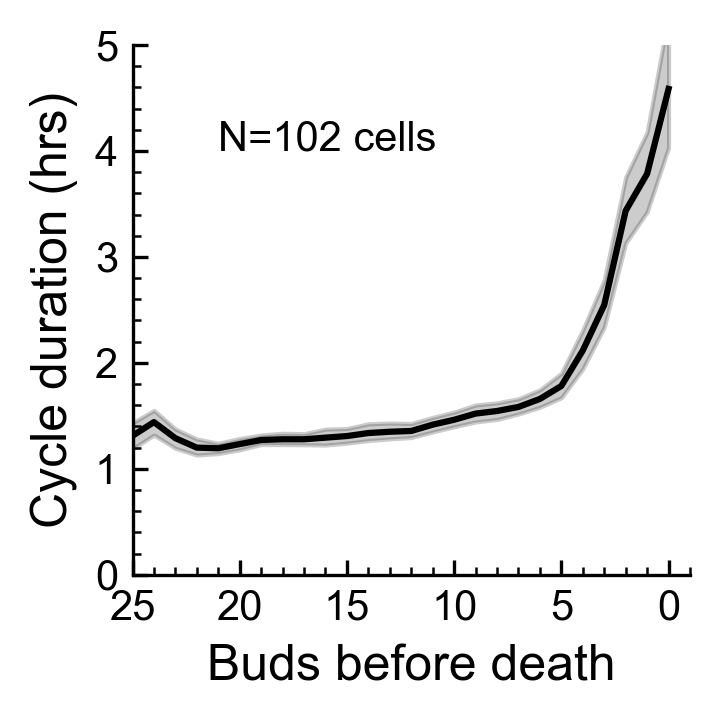

In [37]:
strains = ['JPC000']
ratecolor = strains_color_dict[strains[0]]

sub_bud_df = buds_df[buds_df.strain_name.isin(strains)]
sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
yvar1 = 'cycle_duration_hrs_meanfilt_3'
yvar2 = 'b'
xvar = 'dist_from_sen'
alpha = 0.7
size = 15
fontsize=12
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'

# ax.scatter(sub_fits_df.dist_from_sen, sub_fits_df.b, color=ratecolor,
#            edgecolor=None, alpha=0.2, s=25)
# sns.lineplot(x=xvar,y=yvar, data=sub_fits_df, color=ratecolor)


ax.set_xlim(25, -1)
ax.set_xticks([25, 20, 15, 10, 5, 0])
ax.set_ylim(0, 5)
sns.lineplot(x=xvar, y=yvar1, data=sub_bud_df,ax=ax, color='black')

# ax2 = ax.twinx()
# ax2.spines['top'].set_visible(False)
# ax2.set_ylim(0, 4)

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=1)
# plotting.format_ticks(ax2, xminorspace=1)

ax.set_ylabel(ylabel1, fontsize=fontsize)
# ax2.set_ylabel(y2label, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)
# Plot some stats
n = len(sub_bud_df.celldex.unique())
xy_n = (21, 4)
ax.annotate(f'N={n} cells', xy=xy_n)
plt.tight_layout()
name = '-'.join(strains)
savepath = os.path.join(os.getcwd(), f'plots\\{name}_{yvar1}_vs._{xvar}.png')
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC000_cycle_duration_hrs_meanfilt_3_vs._cycle_number.png


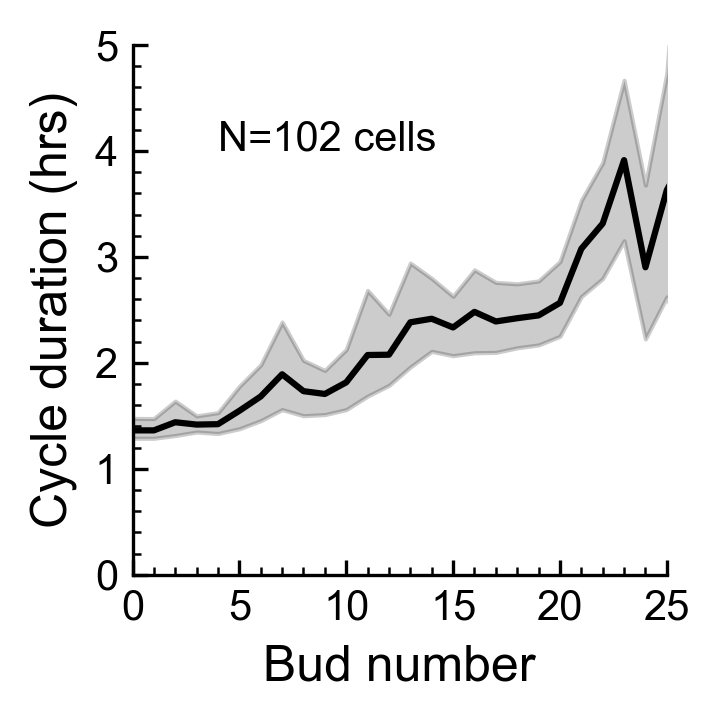

In [35]:
strains = ['JPC000']
ratecolor = strains_color_dict[strains[0]]

sub_bud_df = buds_df[buds_df.strain_name.isin(strains)]
sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
yvar1 = 'cycle_duration_hrs_meanfilt_3'
yvar2 = 'b'
xvar = 'cycle_number'
alpha = 0.7
size = 15
fontsize=12
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Bud number'

# ax.scatter(sub_fits_df.dist_from_sen, sub_fits_df.b, color=ratecolor,
#            edgecolor=None, alpha=0.2, s=25)
# sns.lineplot(x=xvar,y=yvar, data=sub_fits_df, color=ratecolor)


ax.set_xlim(0, 25)
ax.set_xticks([0, 5, 10, 15, 20, 25])
ax.set_ylim(0, 5)
sns.lineplot(x=xvar, y=yvar1, data=sub_bud_df,ax=ax, color='black')

# ax2 = ax.twinx()
# ax2.spines['top'].set_visible(False)
# ax2.set_ylim(0, 4)

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=1)
# plotting.format_ticks(ax2, xminorspace=1)

ax.set_ylabel(ylabel1, fontsize=fontsize)
# ax2.set_ylabel(y2label, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)

# Plot some stats
n = len(sub_bud_df.celldex.unique())
xy_n = (4, 4)
ax.annotate(f'N={n} cells', xy=xy_n)

plt.tight_layout()
name = '-'.join(strains)
savepath = os.path.join(os.getcwd(), f'plots\\{name}_{yvar1}_vs._{xvar}.png')
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

In [63]:
budsmdf = pd.read_csv(r"C:\Users\johnp\Dropbox\Projects\byc\data\20220211_byc\20220211_byc_JPC157_ubr2d_rls_expt_bud_rois.csv")

In [74]:
# reload(fitting_tools)
# reload(database)
# db = database.BudDataBase(budsmdf)
# buddf = db.buddf
# budtable = buddf.pivot_table(index='cell_index', aggfunc=np.median)
survival_df = budtable
survival_df.loc[:, 'end_event_type'] = 'death'
survival_df = fitting_tools.annotate_mdf_censors(survival_df)
survival_fit = fitting_tools.survival_fit(survival_df)

c:\.byc\lib\site-packages\lifelines\utils\__init__.py:1181: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC000_fraction_surviving_kaplan-meier_vs._generations.png


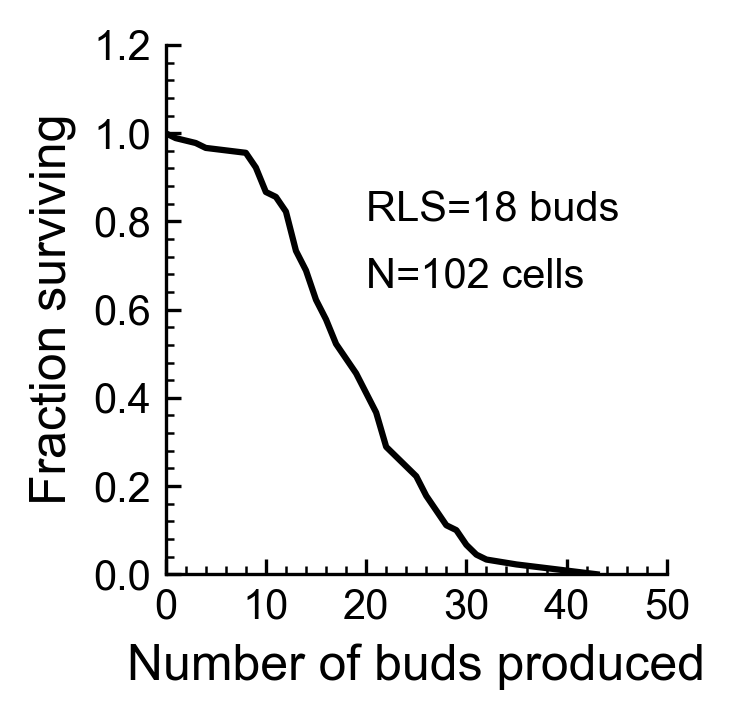

In [90]:
y, x = (survival_fit['y_kmf'], survival_fit['x_kmf'])
rls = survival_fit['kmf_halflife']

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
yvar1 = 'fraction_surviving_kaplan-meier'
xvar = 'generations'
alpha = 0.7
size = 15
fontsize=12
ylabel1 = 'Fraction surviving'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Number of buds produced'

ax.set_xlim(0, 50)
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_ylim(0, 1.2)
ax.plot(x, y, color='black')

# ax2 = ax.twinx()
# ax2.spines['top'].set_visible(False)
# ax2.set_ylim(0, 4)

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=2)
# plotting.format_ticks(ax2, xminorspace=1)

ax.set_ylabel(ylabel1, fontsize=fontsize)
# ax2.set_ylabel(y2label, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)

# Plot some stats
rls_xy = (20, 0.8)
n_xy = (20, 0.65)
ax.annotate(f'RLS={int(rls)} buds', xy=rls_xy)
ax.annotate(f'N=102 cells', xy=n_xy)
plt.tight_layout()
name = '-'.join(strains)
savepath = os.path.join(os.getcwd(), f'plots\\{name}_{yvar1}_vs._{xvar}.png')
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

## Figure 3: Trajectory of single cell ubiquitin-dependent proteasome substrate turnover during senescence approach

### Subselecting multi-measurement cells

In [12]:
compartment = '20190726_byc_pJC010_pdr5d_DsRed-P2A-UBL-YFP-NS'
subdf = fits_df[fits_df.compartment_name==compartment]

countstable = subdf.pivot_table(index='celldex', aggfunc='count')
multi_meas_celldices = countstable[countstable.Mean_yfp_auto>1].index.unique()
multi_meas_celldices = list(multi_meas_celldices)
multisubdf = subdf.set_index('celldex').loc[multi_meas_celldices, :].reset_index()

buddfs = []
for celldex in multi_meas_celldices:
    buddf = buds_df.set_index('celldex').loc[celldex, :]
    buddfs.append(buddf.reset_index())

subbuddf = buds_df.set_index('celldex').loc[multi_meas_celldices, :].reset_index()

C:\Users\johnp\AppData\Local\Temp/ipykernel_14252/2859695342.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


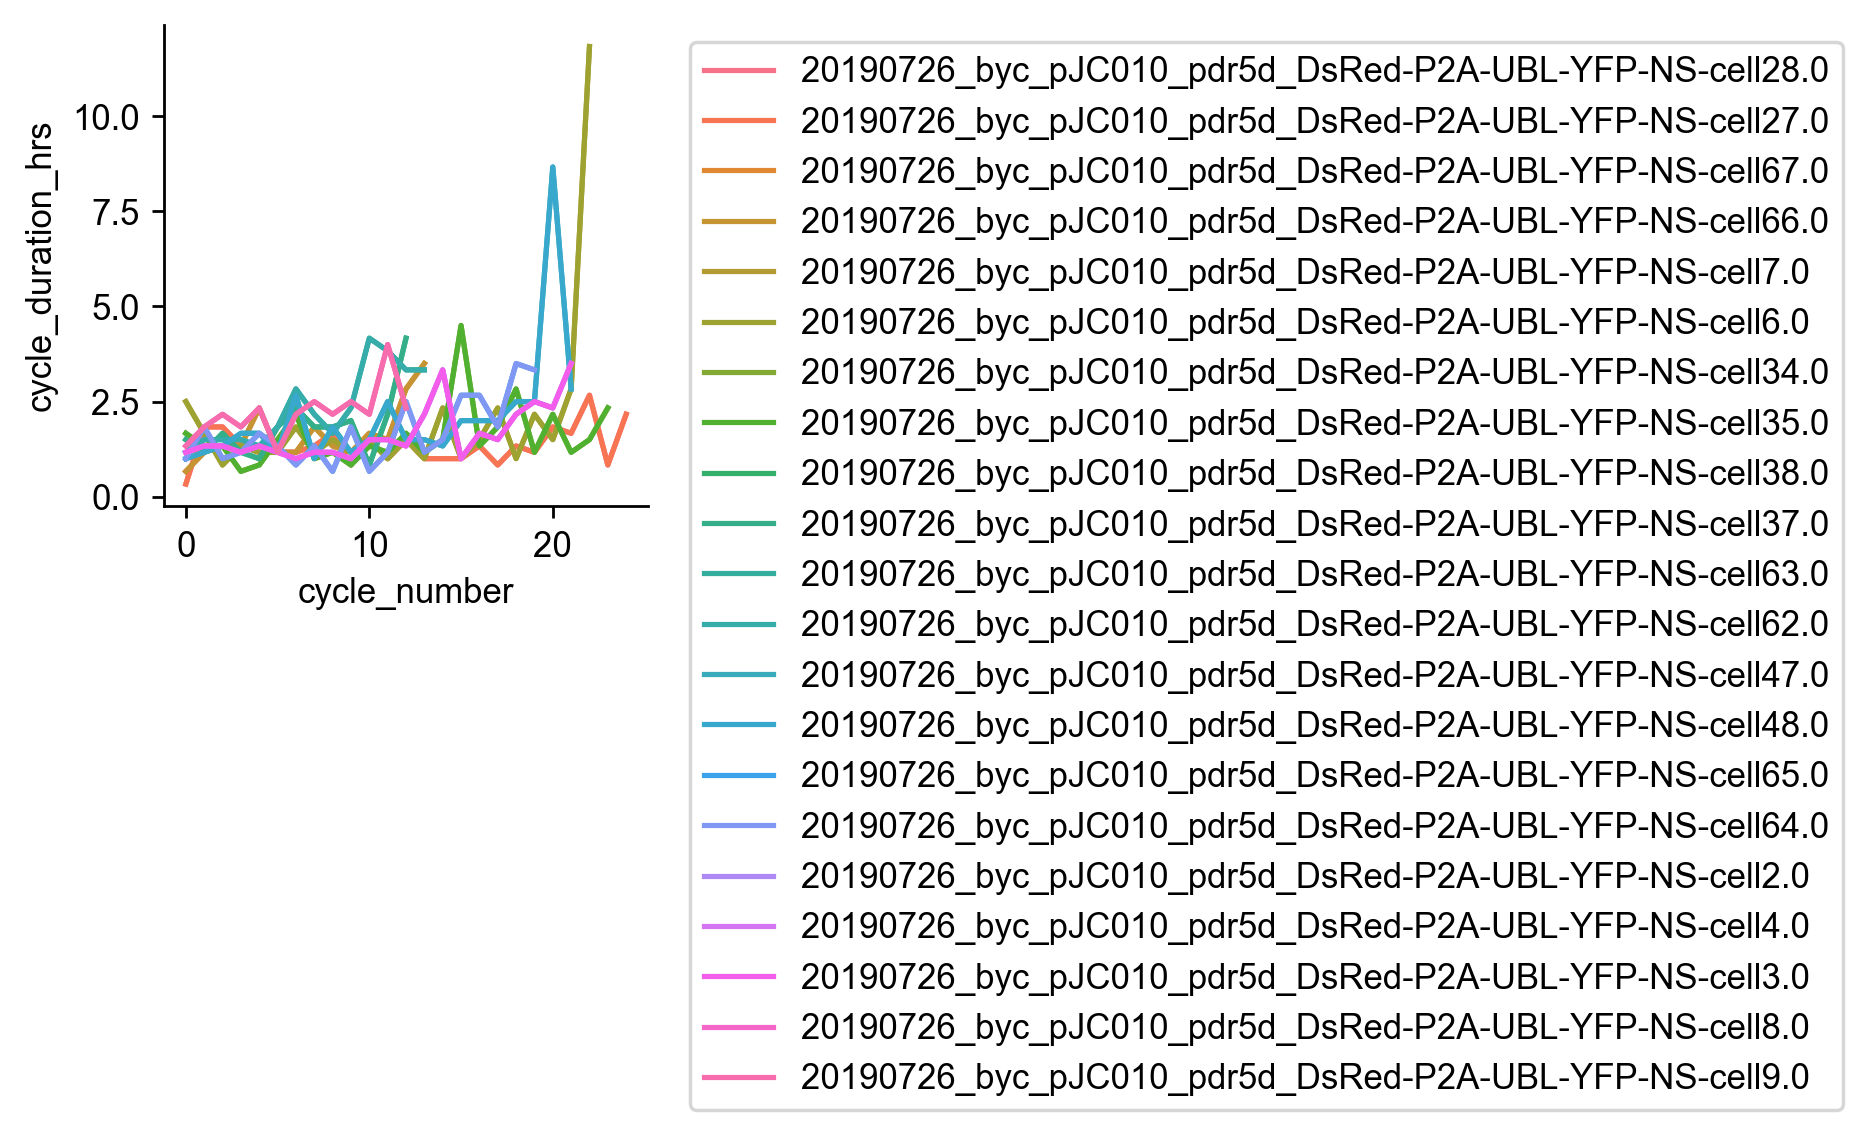

In [15]:
fig, ax = plotting.figure_ax(width_scale=1)

kwargs = {
    'x': 'cycle_number',
    'y': 'cycle_duration_hrs',
    'data': subbuddf,
    'hue': 'measdex',
    'ax': ax
}

sns.lineplot(**kwargs)
plotting.legend_outside()
plt.tight_layout()

In [172]:
subdf.loc[:, ['measdex', 'n_long_buds', 'b']].sort_values(by='n_long_buds', ascending=False).loc[1526, 'measdex']

'20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry-cell46.0'

In [171]:
subdf.loc[:, ['measdex', 'n_long_buds', 'b']].sort_values(by='n_long_buds', ascending=True).head()

measdex  n_long_buds         b
1371   20220825_byc_JPC121_two-chase_1000xetOH-cell31.0          0.0  1.208664
1526  20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry-c...          0.0  1.895656
1512  20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry-c...          0.0  2.630551
1511  20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry-c...          0.0  1.866463
1510  20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry-c...          0.0  1.846578

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\daughter_cell_b.png


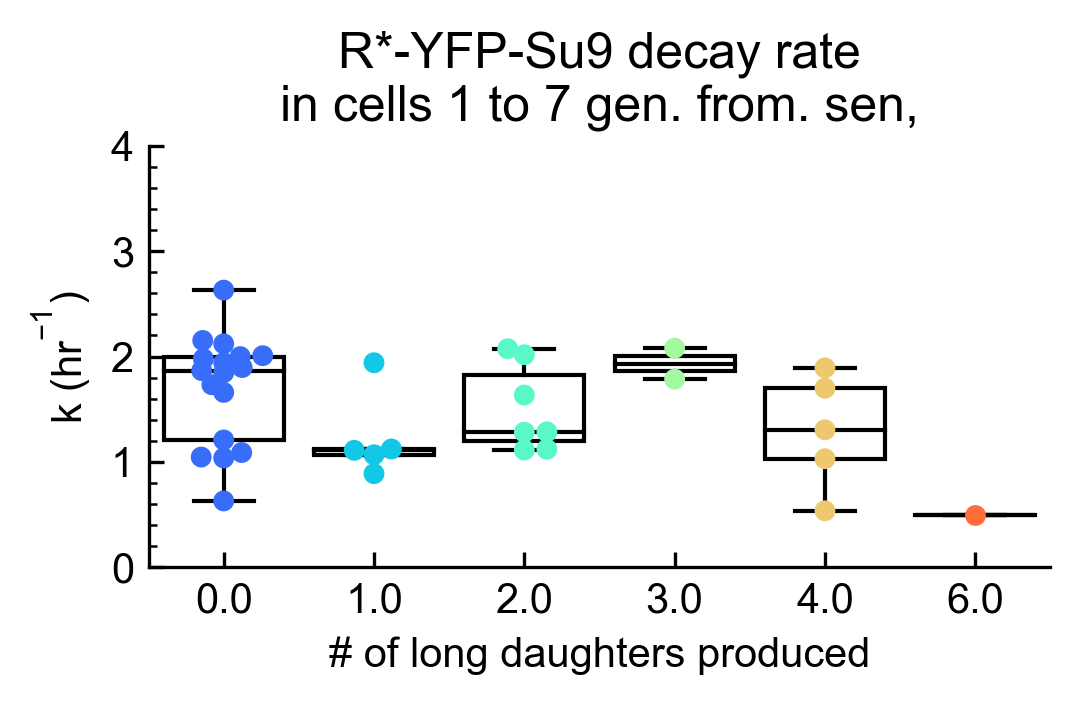

In [92]:
from ctypes import alignment
compartments = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]
subdf = fits_df[fits_df.compartment_name.isin(compartments)]
subdf = subdf[subdf.dist_from_sen<=7]
subdf = subdf[subdf.dist_from_sen>=1]
fig, ax = plotting.figure_ax(width_scale=1.5, dpi=300)
fig.set_dpi(300)
astr = plotting.annoying_strings()

subdf.loc[:, 'long_daughter_summary'] = 'None'
subdf.loc[subdf.n_long_buds>0, 'long_daughter_summary'] = 'At least 1'

boxkwargs = {
    'x': 'n_long_buds',
    'y': 'b',
    'data': subdf,
    'ax': ax,
    'color': 'black',
    'showfliers': False
}

swarmkwargs = {
    'x': 'n_long_buds',
    'y': 'b',
    'data': subdf,
    'ax': ax,
    'palette': 'rainbow'
}

sns.boxplot(**boxkwargs)
sns.swarmplot(**swarmkwargs)
plotting.transparent_boxes(ax)

ax.set_title('R*-YFP-Su9 decay rate\nin cells 1 to 7 gen. from. sen,', loc='center')
ax.set_xlabel('# of long daughters produced')
ax.set_ylabel(astr.k_inverse_hrs)
ax.set_ylim(0, 4)

plt.tight_layout()

plotting.format_ticks(ax, add_minor_x=False)

savepath = os.path.join(constants.byc_data_dir, 'meta/plots/daughter_cell_b.png')
fig.savefig(savepath)
print(f'Saved figure at\n{os.path.abspath(savepath)}')

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.png


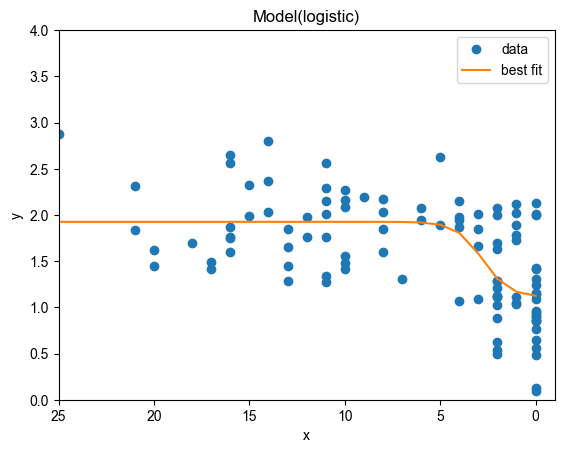

<Figure size 640x480 with 0 Axes>

In [98]:
fitsdf = fitting_tools.fit_logistic_to_fits_df(sub_fits_df)

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.csv
Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.csv
Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC121_allk_and_cycle_vs._dist_from_sen.png


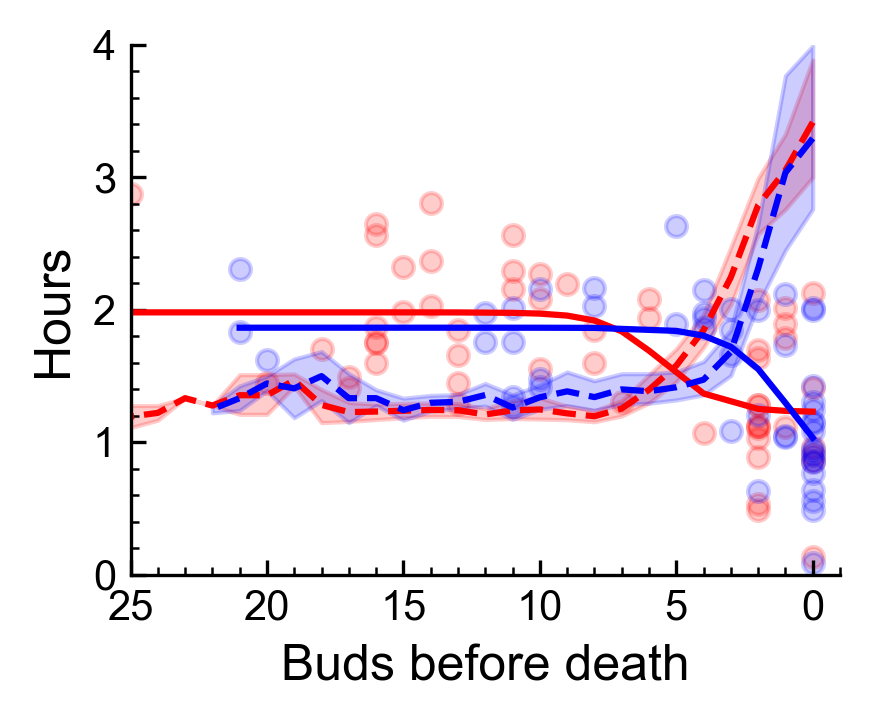

In [5]:
strains = ['JPC121']
compartments = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]
sub_fits_df = fits_df[fits_df.compartment_name.isin(compartments)]
sub_bud_df = buds_df[buds_df.compartment_name.isin(compartments)]


daughter_shape = 'all'
round_fits_df = sub_fits_df[sub_fits_df.n_long_buds==0]
round_bud_df = sub_bud_df[sub_bud_df.n_long_buds==0]

long_fits_df = sub_fits_df[sub_fits_df.n_long_buds>0]
long_bud_df = sub_bud_df[sub_bud_df.n_long_buds>0]

fig, ax = plotting.figure_ax(width_scale=1.2)
fig.set_dpi(300)
yvar1 = 'cycle_duration_hrs_meanfilt_3'
yvar2 = 'b'
xvar = 'dist_from_sen'
alpha = 0.785
size = 15
fontsize=12
ylabel1 = 'Hours'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'
# Make axes
ax.set_xlim(25, -1)
ax.set_xticks([25, 20, 15, 10, 5, 0])
ax.set_ylim(0, 4)


# Plot Long daughters
fitsdf = fitting_tools.fit_logistic_to_fits_df(long_fits_df)
params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
x = np.sort(long_fits_df[xvar].unique())
y_pred = fitting_tools.logistic(x, *params)

sns.lineplot(x=xvar, y=yvar1, data=long_bud_df,ax=ax, color='red', linestyle='--')
ax.scatter(long_fits_df[xvar], long_fits_df[yvar2], color='red',
           edgecolor=None, alpha=0.2, s=25)
ax.plot(x, y_pred, color='red')
# Plot round daughters
fitsdf = fitting_tools.fit_logistic_to_fits_df(round_fits_df)
params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
x = np.sort(round_fits_df[xvar].unique())
y_pred = fitting_tools.logistic(x, *params)
sns.lineplot(x=xvar, y=yvar1, data=round_bud_df,ax=ax, color='blue', linestyle='--')
ax.scatter(round_fits_df[xvar], round_fits_df[yvar2], color='blue',
           edgecolor=None, alpha=0.2, s=25)
ax.plot(x, y_pred, color='blue')


colors = sns.palettes.color_palette('hls', 3)

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=1)

ax.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)
name = '-'.join(strains)
savepath = os.path.join(os.getcwd(), f'plots\\{name}_{daughter_shape}k_and_cycle_vs._dist_from_sen.png')

plt.tight_layout()
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

## Figure 4: F0 daughter cell ubiquitin-dependent proteasome substrate turnover declines with mother cell's senescence proximity

### Read in data

In [34]:
compartmentname_d = "20210430_(RKK-sYFP2-Su9)x2_JPC063_old_daughter_chase"
exptname = '20210430_byc'
compartmentdir_d = files.get_byc_compartmentdir(exptname, compartmentname)

compartmentname_m = "20210430_(RKK-sYFP2-Su9)x2_JPC063_old_daughter_chase"
compartmentdir_m = files.get_byc_compartm   entdir(exptname, compartmentname)

exptdir = os.path.join(constants.byc_data_dir, exptname)

fits_df_d = pd.read_csv(os.path.join(exptdir, '20210430_old_daughter_RKK-sYFP2-Su9_JC359_JPC063_decay_fits.csv'))
fits_df_m = pd.read_csv(os.path.join(exptdir, '20210430_old_RKK-sYFP2-Su9_JC359_JPC063_decay_fits.csv'))

fits_df_d.loc[:, 'mother_daughter'] = 'daughter'
fits_df_m.loc[:, 'mother_daughter'] = 'mother'
wanted_mother_cell_indices = list(fits_df_d.cell_index.unique())

fits_df_md = pd.concat([fits_df_d, fits_df_m.loc[fits_df_m.cell_index.isin(wanted_mother_cell_indices)]]).reset_index()

In [38]:
wanted_mother_cell_indices

[3, 6, 8, 10, 11, 16, 25, 30, 39]

### Representative trace plots

In [161]:
# Cell 8 is a good fast mother and daughter
# Cell 6 is a good fast mother and daughter
for cell_index in wanted_mother_cell_indices:
    subdf = fits_df_md[fits_df_md.cell_index==cell_index]
    dist_from_sen = int(subdf.dist_from_sen.iloc[0])
    colors = sns.color_palette('viridis', max_dist_from_sen+1)
    colors_list = [c for c in colors]
    colors_list.reverse()
    color = colors_list[dist_from_sen]
    fig, ax = plotting.figure_ax()
    fig.set_dpi(300)
    linekwargs = {
        'x': 'x_input',
        'y': 'y_pred_norm',
        'style': 'mother_daughter',
        'style_order': ['mother', 'daughter'],
        'data': subdf,
        'ax': ax,
        'color': color
    }

    sns.lineplot(**linekwargs)

    scatterkwargs = {
        'x': 'x_input',
        'y': 'y_pred_norm',
        'style': 'mother_daughter',
        'style_order': ['mother', 'daughter'],
        'data': subdf,
        'ax': ax,
        'color': colors_list[dist_from_sen]
    }

    sns.scatterplot(**scatterkwargs)

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.2)
    plotting.format_ticks(ax)
    plotting.legend_outside()

    ax.set_xlabel('Hours after chase')
    ax.set_ylabel('YFP/YFP(t0)')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='o', color=color, lw=2),
                    Line2D([0], [0], marker='x', linestyle='--', color=color, lw=2),]

    ax.legend(custom_lines, ['Mother cell', 'Daughter cell'], frameon=False, loc='best')
    print(f'Rates {fits_df_md[fits_df_md.cell_index==cell_index].b.unique()}')
    plt.tight_layout()
    filetype = '.png'
    filename = f'meta/plots/{exptname}_cell{cell_index}_mother-daughter_dist_from_sen={dist_from_sen}{filetype}'
    savepath = os.path.abspath(os.path.join(constants.byc_data_dir, filename))
    fig.savefig(savepath)
    print(f'Saved figure at\n{savepath}')
    plt.close(fig)

Rates [1.14103168 1.34193193]
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20210430_byc_cell3_mother-daughter_dist_from_sen=4.png
Rates [0.84176562 1.03915444]
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20210430_byc_cell6_mother-daughter_dist_from_sen=2.png
Rates [2.24291766 1.97589049]
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20210430_byc_cell8_mother-daughter_dist_from_sen=6.png
Rates [0.84068063 1.88601066]
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20210430_byc_cell10_mother-daughter_dist_from_sen=0.png
Rates [1.07060976 2.39064257]
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20210430_byc_cell11_mother-daughter_dist_from_sen=14.png
Rates [2.2089198  1.51113524]
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20210430_byc_cell16_mother-daughter_dist_from_sen=18.png
Rates [0.60554916 0.90691605]
Saved figure at
C:\Users\johnp\Dropbox\Projects

### Mother vs. daughter decay rate scatter plot

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20210430_byc_daughter_vs_mother_rate_scatterplot.png


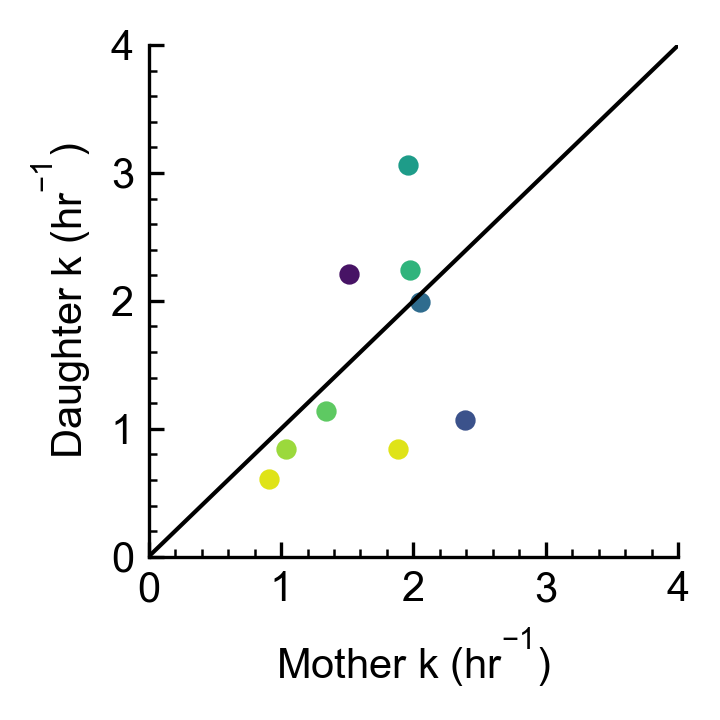

In [160]:
tables = []
for df in [fits_df_m, fits_df_d]:
    table = df.pivot_table(index='cell_index', aggfunc=np.median).reset_index()
    table = table[table.cell_index.isin(wanted_mother_cell_indices)].reset_index()
    table.sort_values(by='cell_index', inplace=True)
    tables.append(table)

table_m, table_d = tables

corr_dict = {
    'mother_decay_rate': table_m.b,
    'daughter_decay_rate': table_d.b,
    'cell_index': table_m.cell_index,
    'dist_from_sen': table_m.dist_from_sen
}

corr_df = pd.DataFrame(corr_dict)
fig, ax = plotting.figure_ax()
fig.set_dpi(300)

colors = sns.color_palette('viridis', int(np.max(corr_df.dist_from_sen))+1)
colors_list = [c for c in colors]
colors_list.reverse()

for cell_index in corr_df.cell_index.unique():
    subdf = corr_df[corr_df.cell_index==cell_index]
    x = subdf.mother_decay_rate.iloc[0]
    y = subdf.daughter_decay_rate.iloc[0]
    dist_from_sen = int(subdf.dist_from_sen.iloc[0])

    color = colors_list[dist_from_sen]
    ax.scatter(x, y, color=color, s=15)

# ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3]
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

# ax.set_xticks(ticks)

plotting.format_ticks(ax, xminorspace=0.2, yminorspace=0.2)
straight_line_x = np.arange(0, np.max(ax.get_xlim())+0.2, 0.5)
straight_line_y = fitting_tools.line(straight_line_x, 1, 0)
ax.plot(straight_line_x, straight_line_y, linewidth=1, color='black')
kinv = plotting.annoying_strings().k_inverse_hrs
ax.set_xlabel(f'Mother {kinv}')
ax.set_ylabel(f'Daughter {kinv}')

plt.tight_layout()
filetype = '.png'
filename = f'meta/plots/{exptname}_daughter_vs_mother_rate_scatterplot{filetype}'
savepath = os.path.abspath(os.path.join(constants.byc_data_dir, filename))
fig.savefig(savepath)
print(f'Saved figure at\n{savepath}')
# plt.close(fig)



Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC063_logistic-fit_b-vs-dist-from-sen.csv
Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC063_logistic-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta/plots/20210430_byc_Mother_vs_daughter_All_k_and_cycle_vs._dist_from_sen_filledsep=False_fittype=logistic.png


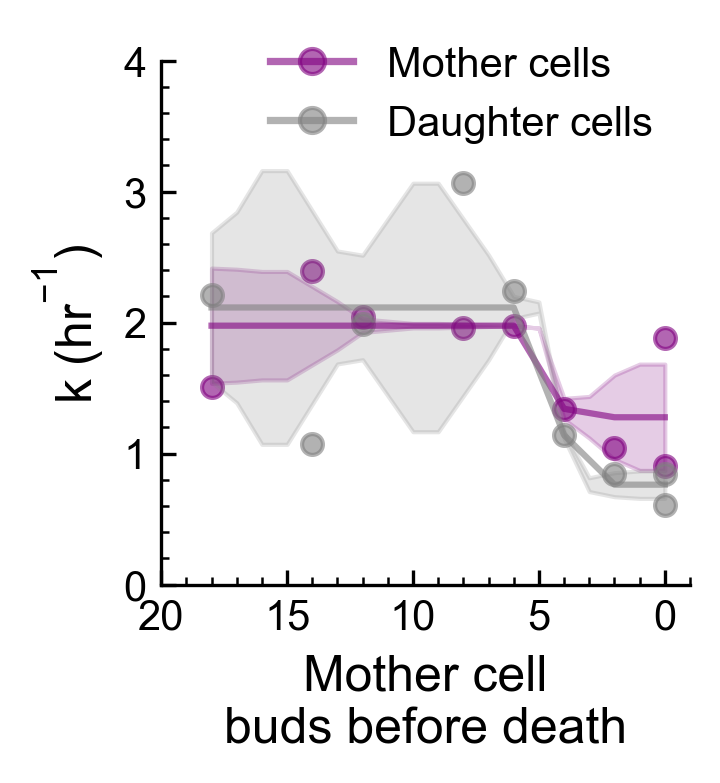

In [185]:
strains = ['JPC121']
compartments = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]

sub_fits_df = fits_df_md
linealpha = 0.6
ratecolor = strains_color_dict[strains[0]]
pre_post_SEP_palette = [
    (42/255, 212/255, 255/255),
    (153/255, 153/255, 153/255)
]

fit_type = 'logistic'
shade_stderr = True
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax(height_scale=1.1)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs_meanfilt_3'
xvar = 'dist_from_sen'
alpha = 0.785
size = 15
fontsize=12
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Mother cell\nbuds before death'

styles = ['-', '--']
markers = ['o', 'x']
colors = ['purple', 'gray']
for i, sub_fits_df in enumerate([table_m, table_d]):
    sub_fits_df.loc[:, 'strain_name'] = 'JPC063'
    if fillsep:
        # Shade post-SEP area
        xfill = np.arange(-1, 7, 1)
        ax.fill_between(
            xfill,
            np.full(len(xfill), 4),
            color=pre_post_SEP_palette[1],
            alpha=fillalpha,
            edgecolor=None)
        # Shade post-SEP area
        xfill = np.arange(7, 26, 1)
        ax.fill_between(
            xfill,
            np.full(len(xfill), 4),
            color=pre_post_SEP_palette[0],
            alpha=fillalpha,
            edgecolor=None)

    if fit_type=='logistic':
        # fit to logistic
            fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
            kernsize = 3
            trace_tools.mean_filter(
                smoothdf,
                'stderr',
                kernsize,
                name_with_kernel=True)  

            params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
            x = np.sort(sub_fits_df[xvar].unique())
            y_pred = fitting_tools.logistic(x, *params)
    elif fit_type=='line':
        # Fit to line
        fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
        y_pred = fitting_tools.line(x, *params)

    else:
        print(f'No fit type <{fit_type}>. Please use either logistic or line')
    # Derive statistics of fit
    r_sq = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df)
    n = len(sub_fits_df)
    # Shade standard error of the mean for 
    if shade_stderr:
        xvar_fill = 'x_input_smooth'
        yvar_fill = 'y_pred'
        errvar = f'stderr_meanfilt_{kernsize}'
        # errvar = f'stderr'

        err_kwargs = {
            'x': smoothdf[xvar_fill],
            'y1': smoothdf[yvar_fill] + smoothdf[errvar],
            'y2': smoothdf[yvar_fill] - smoothdf[errvar]}

        kwargs = {
            'x': xvar_fill,
            'y': 'y_pred',
            'data': smoothdf,
            'err_kws': err_kwargs}
        ax.fill_between(
            err_kwargs['x'],
            err_kwargs['y1'],
            err_kwargs['y2'],
            color=colors[i],
            alpha=0.2
            )
    # Formatting stuff
    ax.set_xlim(20, -1)
    ax.set_xticks([20, 15, 10, 5, 0])
    ax.set_ylim(0, 4)

    ax.scatter(sub_fits_df[xvar], sub_fits_df[yvar1],
            color=colors[i], alpha=linealpha, s=25)
    ax.plot(x, y_pred, color=colors[i], alpha=linealpha)

    plotting.remove_spines(ax)
    plotting.format_ticks(ax, xminorspace=1)
    plotting.format_ticks(ax2, xminorspace=1)

    ax.set_ylabel(ylabel2, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)

    # # Annotate stats
    # xy_n = (23, 3.5)
    # xy_rsq = (23, 3.05)
    # rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 3)}'
    # n_str = f'N={np.round(n, 2)} cells'
    # ax.annotate(rsq_str, xy_rsq)
    # ax.annotate(n_str, xy_n)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], marker='o', alpha=linealpha, lw=1.75),
                Line2D([0], [0], color=colors[1], marker='o', alpha=linealpha, lw=1.75)]
bbox = (0.2, 0.7, 0.8, 0.4)
ax.legend(custom_lines, ['Mother cells', 'Daughter cells'], frameon=False, bbox_to_anchor=bbox)
savedir = os.path.join(constants.byc_data_dir, 'meta/plots/')
savepath = os.path.join(savedir, f'{exptname}_Mother_vs_daughter_{daughter_shape}_k_and_cycle_vs._dist_from_sen_filledsep={fillsep}_fittype={fit_type}.png')
plt.tight_layout()
fig.savefig(savepath)
print(f'Saved figure at\n{savepath}')

In [ ]:
# Cell 8 is a good fast mother and daughter
# Cell 16 is a good fast mother and daughter
# Cell 25
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
cell_index = 39
linekwargs = {
    'x': 'x_input',
    'y': 'y_input_norm',
    'style': 'mother_daughter',
    'hue': 'cell_index',
    'data': fits_df_md[fits_df_md.cell_index==cell_index],
    'ax': ax,
    'palette': 'rainbow'
}

sns.lineplot(**linekwargs)

ax.set_xlim(0, 2)
ax.set_ylim(0, 1.2)
plotting.format_ticks(ax)
plotting.legend_outside()

ax.set_xlabel('Hours after chase')
ax.set_ylabel('YFP/YFP(t0)')

## Figure 5: Decreased ubiquitin-dependent PQC degradation flux rescues degradation of ubiquitin-dependent proteasome substrate

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC136_logistic-fit_b-vs-dist-from-sen.csv
Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC193_logistic-fit_b-vs-dist-from-sen.csv
Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121_logistic-fit_b-vs-dist-from-sen.csv
Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC196_logistic-fit_b-vs-dist-from-sen.csv
Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC136-JPC193-JPC121-JPC196_Allk_and_cycle_vs._dist_from_sen_filledsep=False_fittype=logistic.png


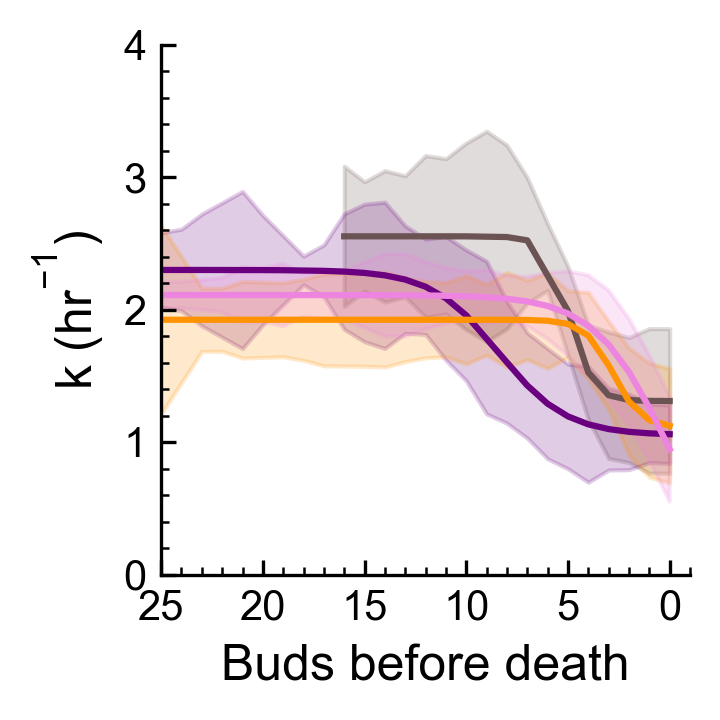

In [323]:
compartments = [
    '20220825_byc_JPC121_two-chase_1000xetOH',
    '20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry'
]

strains_to_plot = [
    ['JPC136'],
    ['JPC193'],
    ['JPC121'],
    ['JPC196']
]


pre_post_SEP_palette = [
    (42/255, 212/255, 255/255),
    (153/255, 153/255, 153/255)
]

fit_type = 'logistic'
shade_stderr = True
scatterplot_rate = False
plot_cycle_duration = False
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs_meanfilt_3'
xvar = 'dist_from_sen'
alpha = 0.785
size = 15
fontsize=12
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'

for strains in strains_to_plot:

    sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
    sub_bud_df = buds_df[buds_df.strain_name.isin(strains)]

    if strains == ['JPC121']:
        sub_fits_df = fits_df[fits_df.compartment_name.isin(compartments)]
        sub_bud_df = buds_df[buds_df.compartment_name.isin(compartments)]

    ratecolor = strains_color_dict[strains[0]]
    if fillsep:
        # Shade post-SEP area
        xfill = np.arange(-1, 7, 1)
        ax.fill_between(
            xfill,
            np.full(len(xfill), 4),
            color=pre_post_SEP_palette[1],
            alpha=fillalpha,
            edgecolor=None)
        # Shade post-SEP area
        xfill = np.arange(7, 26, 1)
        ax.fill_between(
            xfill,
            np.full(len(xfill), 4),
            color=pre_post_SEP_palette[0],
            alpha=fillalpha,
            edgecolor=None)

    if fit_type=='logistic':
        # fit to logistic
            fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
            kernsize = 3
            trace_tools.mean_filter(
                smoothdf,
                'stderr',
                kernsize,
                name_with_kernel=True)  

            params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
            x = np.sort(sub_fits_df[xvar].unique())
            y_pred = fitting_tools.logistic(x, *params)
    elif fit_type=='line':
        # Fit to line
        fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
        y_pred = fitting_tools.line(x, *params)

    else:
        print(f'No fit type <{fit_type}>. Please use either logistic or line')

    
    # Plot the rate vs. generations from death data and fit\
    if scatterplot_rate:
        ax.scatter(sub_fits_df[xvar], sub_fits_df[yvar1], color=ratecolor,
                edgecolor=None, alpha=0.2, s=25)
    ax.plot(x, y_pred, color=ratecolor)
    # Derive statistics of fit
    r_sq = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df)
    n = len(sub_fits_df)
    # Shade standard error of the mean for 
    if shade_stderr:
        xvar_fill = 'x_input_smooth'
        yvar_fill = 'y_pred'
        errvar = f'stderr_meanfilt_{kernsize}'
        # errvar = f'stderr'

        err_kwargs = {
            'x': smoothdf[xvar_fill],
            'y1': smoothdf[yvar_fill] + smoothdf[errvar],
            'y2': smoothdf[yvar_fill] - smoothdf[errvar]
        }

        kwargs = {
            'x': xvar_fill,
            'y': 'y_pred',
            'data': smoothdf,
            'err_kws': err_kwargs
        }
        ax.fill_between(
            err_kwargs['x'],
            err_kwargs['y1'],
            err_kwargs['y2'],
            color=ratecolor,
            alpha=0.2
            )
# Formatting stuff
ax.set_xlim(25, -1)
ax.set_xticks([25, 20, 15, 10, 5, 0])
ax.set_ylim(0, 4)

if plot_cycle_duration:
    ax2 = ax.twinx()
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(0, 4)
    # plot cycl durations
    sns.lineplot(x=xvar, y=yvar2, data=sub_bud_df,ax=ax2, color='black')

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=1)
plotting.format_ticks(ax2, xminorspace=1)

ax2.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_ylabel(ylabel2, fontsize=fontsize, color='black')
ax.set_xlabel(xlabel, fontsize=fontsize)

# Annotate stats
# xy_n = (23, 3.5)
# xy_rsq = (23, 3.05)
# rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 3)}'
# n_str = f'N={np.round(n, 2)} cells'
# ax.annotate(rsq_str, xy_rsq)
# ax.annotate(n_str, xy_n)
name = '-'.join([strains[0] for strains in strains_to_plot])
savepath = os.path.join(os.getcwd(), f'plots\\{name}_{daughter_shape}k_and_cycle_vs._dist_from_sen_filledsep={fillsep}_fittype={fit_type}.png')

plt.tight_layout()
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

c:\.byc\lib\site-packages\lifelines\utils\__init__.py:1181: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\.byc\lib\site-packages\lifelines\utils\__init__.py:1181: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Strain: ['JPC136'], kmf_halflife 11.0, n=68
Strain: ['JPC193'], kmf_halflife 19.0, n=47


c:\.byc\lib\site-packages\lifelines\utils\__init__.py:1181: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Strain: ['JPC122'], kmf_halflife 18.0, n=97
Strain: ['JPC196'], kmf_halflife 15.0, n=114


c:\.byc\lib\site-packages\lifelines\utils\__init__.py:1181: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Saved figure at c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\JPC136-JPC193-JPC122-JPC196_fraction_surviving_kaplan-meier_vs._generations.png


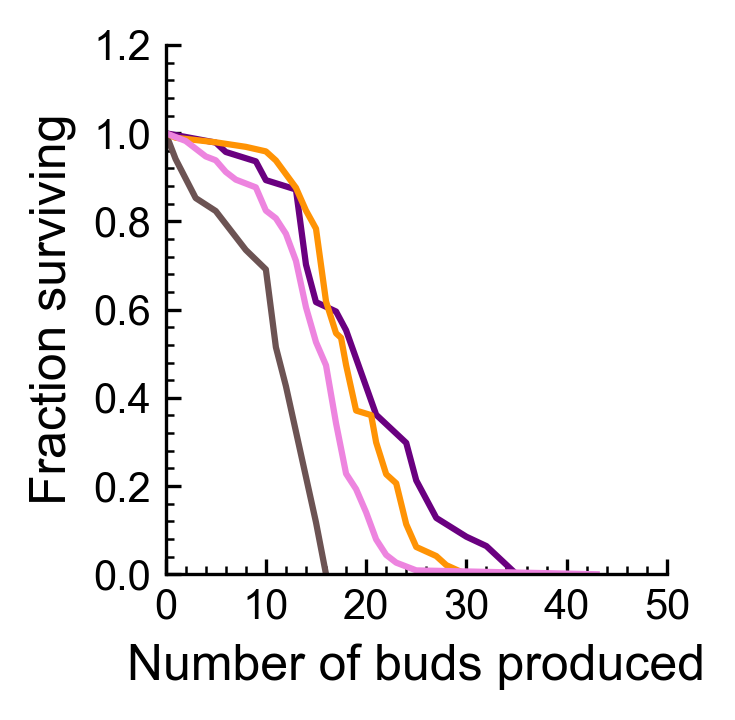

In [4]:
strains_to_plot = [
    ['JPC136'],
    ['JPC193'],
    ['JPC122'],
    ['JPC196']
]

colors = [
    strains_color_dict['JPC136'],
    strains_color_dict['JPC193'],
    strains_color_dict['JPC121'],
    strains_color_dict['JPC196'],
]

# strains_to_plot = [
#     ['JPC193'],
#     ['JPC122'],
# ]

# colors = [
#     strains_color_dict['JPC193'],
#     strains_color_dict['JPC121'],
# ]

fig, ax = plotting.figure_ax()
fig.set_dpi(300)
yvar1 = 'fraction_surviving_kaplan-meier'
xvar = 'generations'
alpha = 0.7
size = 15
fontsize=12
ylabel1 = 'Fraction surviving'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Number of buds produced'

ax.set_xlim(0, 40)
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_ylim(0, 1.2)


for i, strains in enumerate(strains_to_plot):
    sub_bud_df = buds_df[buds_df.strain_name.isin(strains)]
    if strains == ['JPC121']:
        sub_bud_df = buds_df[buds_df.compartment_name.isin(compartments)]
    sub_fits_df = sub_bud_df[sub_bud_df.first_crop_frame<=20]

    survival_df = sub_bud_df.pivot_table(index='cell_index', aggfunc=np.median).reset_index()
    survival_df.loc[:, 'end_event_type'] = 'death'
    survival_df = fitting_tools.annotate_mdf_censors(survival_df)
    survival_fit = fitting_tools.survival_fit(survival_df)
    
    y, x = (survival_fit['y_kmf'], survival_fit['x_kmf'])
    rls = survival_fit['kmf_halflife']
    print(f'Strain: {strains}, kmf_halflife {rls}, n={len(survival_df)}')
    ax.plot(x, y, color=colors[i])

plotting.remove_spines(ax)
plotting.format_ticks(ax, xminorspace=2)
# plotting.format_ticks(ax2, xminorspace=1)

ax.set_ylabel(ylabel1, fontsize=fontsize)
# ax2.set_ylabel(y2label, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)

# Plot some stats
rls_xy = (20, 0.8)
n_xy = (20, 0.65)
# ax.annotate(f'RLS={int(rls)} buds', xy=rls_xy)
# ax.annotate(f'N={len(survival_df)}', xy=n_xy)

plt.tight_layout()
name = '-'.join([strains[0] for strains in strains_to_plot])
savepath = os.path.join(os.getcwd(), f'plots\\{name}_{yvar1}_vs._{xvar}.png')
fig.savefig(savepath)
print(f'Saved figure at {savepath}')

## Figure 6: Integrated model of substrate load on PQC folding and degradation systems approaching senescence

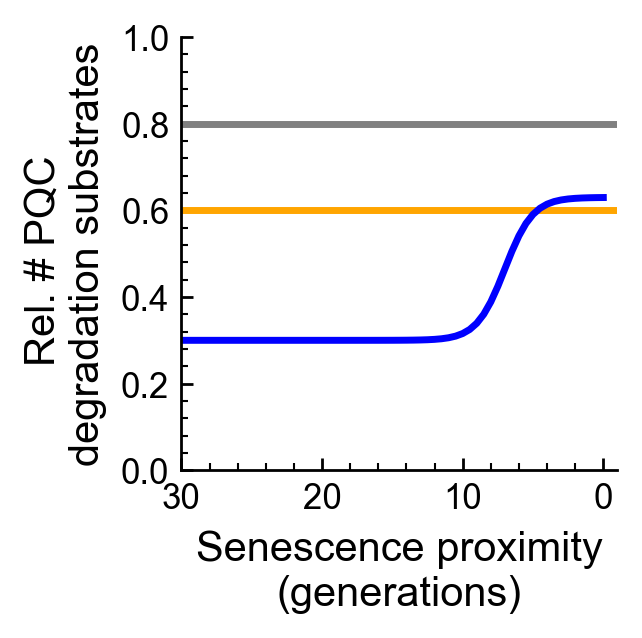

In [3]:
x = np.arange(0, 40, 0.5)
y = ft.logistic(x, 0.33, -1, 7, 0.3)
linewidth = 2
fontsize=12

fig, ax = plotting.figure_ax(width_scale=0.9, height_scale=0.9)

ax.set_xlim(30, -1)
ax.set_ylim(0, 1)

plotting.remove_spines(ax)
plotting.format_ticks(ax)

ax.set_ylabel("Rel. # PQC \ndegradation substrates", fontsize=fontsize)
ax.set_xlabel("Senescence proximity\n(generations)", fontsize=fontsize)

ax.axhline(0.8, color='gray', linewidth=linewidth)
ax.axhline(0.6, color='orange', linewidth=linewidth)

ax.plot(x, y, color='blue', linewidth=linewidth)